In [1]:
 #Summarize, explore, plot Zooplankton data from SoG surveys
# by G Oldford
# Last modified Jul 2022
# to-do: 

# section 1
# supplemental table 1 from 
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245941#sec023
# MODIFIED/Perry2021_Supp1_Tab1.csv

# section 2
# look at the dominant species of each functional group 
#raw downloaded from: https://open.canada.ca/data/en/dataset/2822c11d-6b6c-437e-ad65-85f584522adc
#Ian Perry, R., Young, K., Galbraith, M., Chandler, P., Velez-Espino, A., & Baillie, S. (2021). Zooplankton variability in the Strait of Georgia, Canada, and relationships with the marine survivals of Chinook and Coho salmon. PLoS ONE, 16(1 January), e0245941. https://doi.org/10.1371/journal.pone.0245941

# to do: should adjust for seasonal bias as did Perry et al (2021) by determining season
#        calculating seasonal average biomass and then calculating average annual biomass from those. 
#        Their cutoff for inclusion in seasonal stats were 

In [1]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(stats)
library(treemapify)
library(zoo)
library(RColorBrewer)

#install.packages("treemapify", repos='http://cran.us.r-project.org')

mg_to_g = 0.001

#calc WW biomass density g m-2 from concentration as per Perry et al (pers comm)
# using assumption that all zoop are 85% water (mult by 6.66) and jelly as 95% water
DW_to_WW_zoop = 6.66 # default
DW_to_WW_scyphozoa = 25 # Mean from Larson, 1986 (tab 2): 5% DW; Acuna, Lopez-Urrutia, Colin 2011 - avg of aurelia (52) and cyanea (34) WW:DW
DW_to_WW_medusae = 25 # Mean from Larson, 1986 (Tab 2): 4% DW; Acuna, Lopez-Urrutia, Colin 2011 & Larson, 19- avg of Aequorea (54), WW:DW
DW_to_WW_ctenop = 25 # Based on Larson, 1986, Pleurobrachia brachei 96 percent water 
DW_to_WW_fish = 5 # Omori 1969 Tab 
DW_to_WW_lgcope = 5 # avg from Omori of several lg copepods 
DW_to_WW_medsmcope = 7 # Omori 1969, avg across several
DW_to_WW_chaetognaths = 10 # Nakamura et al, 2007; Pauly et al., 2021
DW_to_WW_mysiids = 5.5 # Omori 1969
DW_to_WW_amphipod = 4 # Omori 1969 (avg of gammarid / hyperiid)
DW_to_WW_insect = 3.6 # Omori 1969 - water strider
DW_to_WW_larvacean = 25 # guesstimate
DW_to_WW_decapods = 10 # Larson, 1986 in Moriarty, 2009
DW_to_WW_euphs = 7.5 # avg of Omori 1969 (4.7) and Moriarty, 2009 (10)
DW_to_WW_ostrac = 4.1 #Nakamura et al, 2007
DW_to_WW_siponophora = 28 #Moriarty, 2009
DW_to_WW_others = 10 #others

# used in unaggregated data analysis for conversion
DW_to_WW_ZC1_EUP = DW_to_WW_euphs
DW_to_WW_ZC2_AMP = DW_to_WW_amphipod
DW_to_WW_ZC3_DEC = DW_to_WW_decapods
DW_to_WW_ZC4_CLG = DW_to_WW_lgcope
DW_to_WW_ZC5_CSM = DW_to_WW_medsmcope

DW_to_WW_ZG1_JEL = DW_to_WW_scyphozoa
DW_to_WW_ZG2_CTH = (DW_to_WW_ctenop + DW_to_WW_siponophora) / 2
DW_to_WW_ZG3_CHA = DW_to_WW_chaetognaths
DW_to_WW_ZG4_LAR = DW_to_WW_larvacean

DW_to_WW_ZF1_FIS = DW_to_WW_fish

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.4
v tibble  2.1.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



# Section 1 - Pre-Aggregated Data Analysis
### using zoop groups as defined in Perry et al (2021)
supplemental table 1 from 
<br> https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245941#sec023
<br>
<br>MODIFIED/Perry2021_Supp1_Tab1.csv


In [3]:
# note no bottom depths < 60 m in these data (already filtered)

path = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//4. Zooplankton//Zoop_Perryetal_2021//MODIFIED//"
file = "Perry2021_Supp2_Tab1.csv"
path_out_TS = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//4. Zooplankton//Zoop_Perryetal_2021//MODIFIED//"

a1996_2018_supp2_df <- read.csv(paste(path, file,sep=""))

# create survey depth difference field for density calc following Perry et al pers. comm. Nov 2021
a1996_2018_supp2_df['depthrange'] = abs(a1996_2018_supp2_df['startz.m'] - a1996_2018_supp2_df['endz.m'])

#print(colnames(a1996_2018_supp2_df))
head(a1996_2018_supp2_df[21:46])


# col indices for first and last indiv groups
col_beg = 21
col_end = 44

########################## WW B dens ####################################
###################################
# convert from DW to WW and to B per square m (depth int following Perry et al)

# gelatinous groups (index)
# Siphonophorae (44), Scyphozoa (43), Ctenophora (30), Larvacea (33), Medusae (34)
WW_B_conc = a1996_2018_supp2_df %>%
  mutate(across(c(21:22), ~(as.numeric(.) * DW_to_WW_amphipod))) %>%
  mutate(across(c(24), ~(as.numeric(.) * DW_to_WW_lgcope))) %>%
  mutate(across(c(25:26,37), ~(as.numeric(.) * DW_to_WW_medsmcope))) %>%
  mutate(across(c(28), ~(as.numeric(.) * DW_to_WW_chaetognaths))) %>%
  mutate(across(c(30), ~(as.numeric(.) * DW_to_WW_ctenop))) %>%
  mutate(across(c(31), ~(as.numeric(.) * DW_to_WW_euphs))) %>%
  mutate(across(c(32), ~(as.numeric(.) * DW_to_WW_fish))) %>%
  mutate(across(c(33), ~(as.numeric(.) * DW_to_WW_larvacean))) %>%
  mutate(across(c(34), ~(as.numeric(.) * DW_to_WW_medusae))) %>%
  mutate(across(c(35), ~(as.numeric(.) * DW_to_WW_mysiids))) %>%
  mutate(across(c(38), ~(as.numeric(.) * DW_to_WW_ostrac))) %>%
  mutate(across(c(43), ~(as.numeric(.) * DW_to_WW_scyphozoa))) %>%
  mutate(across(c(44), ~(as.numeric(.) * DW_to_WW_siponophora))) %>%
  mutate(across(c(23,27,29,36,39,40:42), ~(as.numeric(.) * DW_to_WW_others)))

# convert from WW mg m-3 to WW g m-2
#WW_Bdens_df = a1996_2018_supp2_df %>% 
#  mutate(across(.cols = c(col_beg:col_end),
#                .fns = ~. * depthrange * mg_to_g))  %>%
#  mutate(Total.Biomass = rowSums(. [col_beg:col_end]))

WW_Bdens_df = WW_B_conc %>%
    # convert mg to g
    mutate(across(.cols = c(col_beg:col_end),
                 .fns = ~. * mg_to_g)) %>%
    # convert g m-3 to g m-2
    mutate(across(.cols = c(col_beg:col_end),
                 .fns = ~. * depthrange)) %>%
    mutate(Total.Biomass = rowSums(. [col_beg:col_end])) %>%
    mutate(Total.Biomass.NoEuphs = rowSums(. [c(col_beg:30,32:col_end)])) %>%
    # crustaceans and other hard bodied groups (no fish, euphs, gelat)
    mutate(Total.Biomass.Hard = rowSums(. [c(21,22,24,25,26,28,29,35,36,37,38,40,41,42)])) %>%
    # soft-bodied groups (no fish, euphs, gelat)
    mutate(Total.Biomass.Soft = rowSums(. [c(27,30,33,34,39,43,44)]))


AmphiGam,AmphiHyp,BenthicLarv,CalCops.larg,CalCops.med,CalCops.smal,Cephalopoda,Chaetognatha,Cladocera,Ctenophora,...,NonCalCops,Ostracoda,Other,PolychaetPelagic,Pteropods,Repantia,Scyphozoa,Siphonophorae,Total.Biomass,depthrange
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2.49343,0.27036,0.00894,8.86572,5.63803,0.30471,0.05135,0.15047,0.00000,0,...,0.10340,2.41510,0.29042,0.97444,0.42799,0.00000,0,0.97348,27.13857,400
1.77980,0.26451,0.02184,25.75815,8.80209,0.32579,0.01075,0.17554,0.00382,0,...,0.14079,2.35396,0.00000,0.72774,0.18151,0.00000,0,0.65032,43.90583,400
4.61524,3.10915,0.88579,7.96713,11.46466,1.70843,0.00000,0.69826,0.00000,0,...,0.59765,2.01767,0.00000,2.30619,0.25985,0.01720,0,0.38782,39.34510,400
3.51086,1.65321,0.18250,10.26109,11.23684,1.38025,0.00000,0.40984,0.00000,0,...,0.44741,3.91307,0.04299,2.45235,0.42703,0.31068,0,0.11273,39.16345,400
4.69071,1.08455,0.02484,6.12007,9.92156,0.25526,0.00000,3.31445,0.00000,0,...,0.24930,1.52854,0.00000,1.41343,0.16718,0.00000,0,0.14091,32.35766,400
7.13900,1.26617,0.13864,3.69601,8.49707,1.07810,0.00000,2.50776,0.00000,0,...,0.35234,5.86960,0.00000,1.65617,0.30428,0.00000,0,0.38108,37.79185,400


Note: Using an external vector in selections is ambiguous.
i Use `all_of(col_beg)` instead of `col_beg` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
i Use `all_of(col_end)` instead of `col_end` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [10]:
WW_Bdens_df$depthrange

[1] 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 [19] 400 400 250 253 400 400 400 400 400 310 400 400 400 233 249 400 250 250
 [37] 250 250 250 250 250 250 249 246 250 250 240 227 250 240 188 253 257 233
 [55] 251 201 250 250 250 250 250 250 250 250 250 390 390 400 390 390 250 234
 [73] 250 390 390 239 250 250 250 250 220 220 250 390 390 390 390 230 390 390
 [91] 390 390 390 390 250 250 250 250 400 390 390 380 390 390 400 390 390 390
[109] 390 299 229 249 234 395 165 375 260 130 300 382 400 300 390 390 150 250
[127] 400 148 148 135 390 150 135 140 135 135 150 145 115 130 150 150 128 130
[145] 150 148 150 148 150 148 138 325 366 341 306 150 102  83 150 108 150  52
[163]  96 150 175 240 400 250 240 249 390 150 130 135 150 145 150 150 125 110
[181] 150 105 150 135 135 390 150 130 150 140 150 150 110 125 150 150 150 130
[199] 140 150 125 150 135 150 150 150 145 150 390 230 150 400 150 135 115 130
[217] 150 390 150 106 141 150 148 120 150 150 339 390 400 318 392 315 235 377
[235] 345 300 320 235 395 312  50  50 297 376 227 288 278 343 150 275 390 150
[253] 250 150 315 235 235 321 293 340 399 150 215  95 235 320 285 339 323 238
[271] 393 390 240 340 320 390 120 145 150 135 150 240 378 229 319 297 340 234
[289] 390 250 290 320 240 397 223 165 110 125 150 165 160 325 290 307 340 233
[307] 300 160 231 345 349 390 200 246 250 340 235 130 285 140 234 231 284 130
[325] 405 345 279 315 239 375 135  69 235 393 231 315  63 290 305 343  52 174
[343] 388 125 194 194  61 227 286 126 377 227 285 263 318 415 125 235 136 390
[361] 235 315 280 343 415 124 290  52  82 235 286 141 126 415 342 270 315 235
[379] 389  48 302 289 315 233 342 411 122 390 293 219 312 395 231 325 298 313
[397] 347 231 286 130 390 123 240 323 284 328 413  59 145 234 290 123 250 384
[415] 124 413  64 343 280 314 235  58 306 290 320 245 345 420  68 106 129 395
[433] 298 241 206 250 310 290 390 117 340  90 302 290 326 415 235 145  64 235
[451] 315 280 343 415 124 390 136 290 235 372 127 209 271 118 221 303 294 264
[469] 283 322 235 314 280 343 415 124 390 135 290 237 312 301 145 396 130 420
[487] 240 320 294 305 346 335 165 170 170 120 135 155 390 235 315 280 340 413
[505] 124 131 286 234 231 384 235 314 280 342 413 124 285 136 308 296 314 239
[523] 354 418 129 393 295 230 230 278 142 390 120 410 231 315 290 303 345 330
[541] 114 130 153 169 234 389 162 171 235 314 280 289 135 124 413 338 213 260
[559] 275 110 227 257 257 280 316 387 235 389 235 315 280 343 413 123 126 286
[577] 317 256 342 406 129 388 299 235 340 305 286 305 235 417 123 393 131 300
[595] 231 262 227 143 297 212 117 230 273 228 253 237 237 235 251 245 324 309
[613] 393 338 315 342 303 236 245 235 389 289 242 244 290 135 390 343 315 241
[631] 227 128 297 390 125 415 235 314 290 342 252 395 293 347 349 326 326 326
[649] 326 326 390 343 280 392 290 245 290 315 348 419 130 390 294 232 390 275
[667] 335 150 386 415 305 342 390 245 343 277 235 280 343 390 390 280 342 390
[685] 279 343 124 301 283 340 384 225 390 412 315 288 342 240 234 375 375 232
[703] 309 392 290 345 395 237 317 294 343 308 230 250 392 235 375 295 229 395
[721] 235 345 285 318 377 312 234 293 343 316 233 390 310 230 390 235 319 311
[739] 313 206 386 235 326 280 345 301 344 395 314 229 234 390 309 234 390 290
[757] 345 288 227 390

In [29]:
# problematic outlier? for euphausiids lead to potentially nutty WW estimates (2500 mt / km +)
badones = WW_Bdens_df %>% filter(Total.Biomass > 1000)
badones[c(1:5,31:47)]

# dry weight mg / m-3 estimate that's probably a mistake
bighaul = a1996_2018_supp2_df %>% filter(ï..key == "PBS2009046001401")
bighaul["euphsWW_B_mt_km2"] = bighaul["Euphs"] * mg_to_g * DW_to_WW_euphs * bighaul["depthrange"]
bighaul[c(31,45:47)]

ï..key,survey,event,net,region,Euphs,Fish,Larvacea,Medusae,Mysids,Natantia,NonCalCops,Ostracoda,Other,PolychaetPelagic,Pteropods,Repantia,Scyphozoa,Siphonophorae,Total.Biomass,depthrange,Total.Biomass.NoEuphs
<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
PBS1998017000401,PBS1998017,4,1,Central Strait of Georgia,1188.527,0,0.654875,21.201687,0,0.212175,1.1009075,3.651603,0.00000,2.44925,4.977075,5.050425,0,2.16370,1331.380,250,142.85376
PBS2009046001401,PBS2009046,14,1,Northern Strait of Georgia,2535.916,0,13.542300,0.358425,0,0.000000,0.5068245,0.000000,0.28353,0.00000,0.847725,0.000000,0,4.74726,2584.023,150,48.10682


Euphs,Total.Biomass,depthrange,euphsWW_B_mt_km2
<dbl>,<dbl>,<int>,<dbl>
2254.148,2293.246,150,2535.916


In [30]:

# set seasons following Perry et al 2021
WW_Bdens_df = WW_Bdens_df %>%
  mutate(season = case_when(mon == 12 | mon == 1 | mon == 2 ~ "winter", 
                            mon == 3 | mon == 4 | mon == 5 ~ "spring", 
                            mon == 6 | mon == 7 | mon == 8 ~ "summer", 
                            mon == 9 | mon == 10 | mon == 11 ~ "fall"))

#head(a1996_2018_supp2_df)
#nrow(a1996_2018_supp2_df)
#colnames(a1996_2018_supp2_df)
head(WW_Bdens_df[21:45])

########################## WW B Stats ####################################
###################################

print("Statistics for total.B (transformed to WW)")
summary(WW_Bdens_df$Total.Biomass)
sd(WW_Bdens_df$Total.Biomass)

print("Statistics for total.B (no Euphs)")
summary(WW_Bdens_df$Total.Biomass.NoEuphs)
sd(WW_Bdens_df$Total.Biomass.NoEuphs)

# by season
print("stats of total B by season - not for B param should 'stratify' as in next bit")
WW_Bdens_df %>%
  group_by(season) %>% 
  mutate(meanB = mean(Total.Biomass)) %>%
  mutate(stdev = sd(Total.Biomass)) %>%
  mutate(meanlogB = mean(log(Total.Biomass))) %>% 
  mutate(stddevlogB = sd(log(Total.Biomass))) %>%
  dplyr::select(season, stdev, meanB, meanlogB, stddevlogB) %>%
  summarise(meanB_ = mean(round(meanB, digits=2)),
            stdev = mean(round(stdev, digits=2)),
            meanlogB_ = mean(round(meanlogB, digits=2)),
            stddevlogB_ = mean(round(stddevlogB, digits=2)),
            n_= n()) %>%
  mutate(logmean_B1 = exp(meanlogB_ + stddevlogB_^2/2)) %>%
  mutate(logmean_B2 = exp(meanlogB_ ))

print("Summarize mean B season and year")
WW_Bdens_df %>%
  group_by(season,yr) %>% 
  mutate(meanB = mean(Total.Biomass),
         stdev = sd(Total.Biomass), 
         meanlogB = mean(log(Total.Biomass)), 
         stddevlogB = sd(log(Total.Biomass)),
         meanB_hard = mean(Total.Biomass.Hard),
         stdev_hard = sd(Total.Biomass.Hard),
         meanB_soft = mean(Total.Biomass.Soft),
         stdev_soft = sd(Total.Biomass.Soft),
        ) %>%
    # Total.Biomass.NoEuphs	Total.Biomass.Hard	Total.Biomass.Soft
  #mutate(meanB_NoEuphs = ) %>%
  dplyr::select(season, stdev, meanB, meanlogB, stddevlogB, meanB_hard, stdev_hard, meanB_soft, stdev_soft) %>%
  summarise(meanB_ = mean(round(meanB, digits=2)),
            stdev = mean(round(stdev, digits=2)),
            meanlogB_ = mean(round(meanlogB, digits=2)),
            stddevlogB_ = mean(round(stddevlogB, digits=2)),
            meanB_hard_ = mean(round(meanB_hard, digits=2)),
            stdev_hard_ = mean(round(stdev_hard, digits=2)),
            meanB_soft_ = mean(round(meanB_soft, digits=2)),
            stdev_soft_ = mean(round(stdev_soft, digits=2)),
            n_= n()) %>%
  mutate(logmean_B1 = exp(meanlogB_ + stddevlogB_^2/2)) %>%
  mutate(logmean_B2 = exp(meanlogB_ )) %>%
  ungroup() %>%
  group_by(season) %>%
  mutate(meanB_acrossyrs = mean(meanB_),
         meanB_hard_acrosssyrs = mean(meanB_hard_),
         meanB_soft_acrosssyrs = mean(meanB_soft_)) %>%
  summarise(meanB_acrossyrs_ = mean(round(meanB_acrossyrs, digits=2)),
           meanB_hard_acrosssyrs = mean(round(meanB_hard_acrosssyrs, digits=2)),
           meanB_soft_acrosssyrs = mean(round(meanB_soft_acrosssyrs, digits=2)))

# get mean of each group by season and year
print("Summarize mean B by group, season and year")
seasonal_B_summary = WW_Bdens_df %>%
    dplyr::select(,c(9,21:45,47:50)) %>%
    group_by(season,yr) %>%
    summarise_all(.funs = funs(B = round(mean(., na.rm=TRUE),digits=2))) 
#seasonal_B_summary
# WW_Bdens_df[47:49]

#print("investigate single group: ")
#seasonal_B_summary$Euphs_B

#get mean of each group by year
print("summarize mean B by group and year")
B_yr_summary = seasonal_B_summary %>%
    group_by(yr) %>%
    dplyr::select(-season) %>%
    summarise_all(.funs = funs(B = round(mean(., na.rm=TRUE),digits=2))) %>%
    pivot_longer(2:29, names_to = "group", values_to = "mean_B")
#seasonal_B_yr_summary

# seasonal_B_yr_summary can be used as EwE time series

#print("Investigate single group")
#filter(seasonal_B_yr_summary, group == "Euphs_B_B")

# Average B across years
print("Average B by group across years for model B param")
yearround_B_avg = B_yr_summary %>% 
    group_by(group) %>%
    summarise(mean_B = round(mean(mean_B, na.rm=TRUE),digits=2))
yearround_B_avg

AmphiGam,AmphiHyp,BenthicLarv,CalCops.larg,CalCops.med,CalCops.smal,Cephalopoda,Chaetognatha,Cladocera,Ctenophora,Euphs,Fish,Larvacea,Medusae,Mysids,Natantia,NonCalCops,Ostracoda,Other,PolychaetPelagic,Pteropods,Repantia,Scyphozoa,Siphonophorae,Total.Biomass
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.989488,0.432576,0.03576,17.73144,15.78648,0.853188,0.2054,0.60188,0.00000,0,11.33217,0.06878,0.2064,1.6253,0,0.70312,0.289520,3.960764,1.16168,3.89776,1.71196,0.00000,0,10.902976,75.49665
2.847680,0.423216,0.08736,51.51630,24.64585,0.912212,0.0430,0.70216,0.01528,0,6.89316,0.00692,0.0000,3.3687,0,0.28468,0.394212,3.860494,0.00000,2.91096,0.72604,0.00000,0,7.283584,106.92181
7.384384,4.974640,3.54316,15.93426,32.10105,4.783604,0.0000,2.79304,0.00000,0,1.74072,0.87510,0.0000,9.6394,0,5.31332,1.673420,3.308979,0.00000,9.22476,1.03940,0.06880,0,4.343584,108.74162
5.617376,2.645136,0.73000,20.52218,31.46315,3.864700,0.0000,1.63936,0.00000,0,0.99603,1.36518,0.0000,5.1063,0,5.18948,1.252748,6.417435,0.17196,9.80940,1.70812,1.24272,0,1.262576,101.00385
7.505136,1.735280,0.09936,12.24014,27.78037,0.714728,0.0000,13.25780,0.00000,0,9.79101,0.00430,0.0000,1.0987,0,0.28468,0.698040,2.506806,0.00000,5.65372,0.66872,0.00000,0,1.578192,85.61698
11.422400,2.025872,0.55456,7.39202,23.79180,3.018680,0.0000,10.03104,0.00000,0,1.09941,2.11702,0.0000,1.4139,0,13.35704,0.986552,9.626144,0.00000,6.62468,1.21712,0.00000,0,4.268096,98.94633


[1] "Statistics for total.B (transformed to WW)"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.788   77.953  150.535  190.683  254.375 2584.023 

[1] 173.0265

[1] "Statistics for total.B (no Euphs)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.748  60.402 115.875 143.426 200.452 689.750 

[1] 107.2668

[1] "stats of total B by season - not for B param should 'stratify' as in next bit"


`summarise()` ungrouping output (override with `.groups` argument)


season,meanB_,stdev,meanlogB_,stddevlogB_,n_,logmean_B1,logmean_B2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
fall,186.04,224.06,4.92,0.76,163,182.87448,137.00261
spring,178.49,147.16,4.84,0.91,275,191.33963,126.46935
summer,248.84,163.26,5.29,0.76,239,264.75371,198.34343
winter,72.73,61.03,4.01,0.75,83,73.05773,55.14687


[1] "Summarize mean B season and year"


Adding missing grouping variables: `yr`
`summarise()` regrouping output by 'season' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


season,meanB_acrossyrs_,meanB_hard_acrosssyrs,meanB_soft_acrosssyrs
<chr>,<dbl>,<dbl>,<dbl>
fall,181.41,87.60,23.14
spring,150.94,84.75,37.51
summer,228.98,109.14,46.32
winter,71.52,43.95,8.61


[1] "Summarize mean B by group, season and year"


Warning message:
"`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

[1] "summarize mean B by group and year"
[1] "Average B by group across years for model B param"


`summarise()` ungrouping output (override with `.groups` argument)


group,mean_B
<chr>,<dbl>
AmphiGam_B_B,8.07
AmphiHyp_B_B,3.56
BenthicLarv_B_B,1.92
CalCops.larg_B_B,17.10
CalCops.med_B_B,29.15
CalCops.smal_B_B,3.03
Cephalopoda_B_B,0.07
Chaetognatha_B_B,4.51
Cladocera_B_B,0.06


In [4]:
B_yr_summary %>% 
    filter(group == 'Total.Biomass_B_B')

yr,group,mean_B
<int>,<chr>,<dbl>
1996,Total.Biomass_B_B,99.47
1997,Total.Biomass_B_B,168.87
1998,Total.Biomass_B_B,279.47
1999,Total.Biomass_B_B,320.24
2000,Total.Biomass_B_B,225.81
2001,Total.Biomass_B_B,190.13
2002,Total.Biomass_B_B,105.58
2003,Total.Biomass_B_B,132.84
2004,Total.Biomass_B_B,82.38


In [31]:
yearround_B_avg

group,mean_B
<chr>,<dbl>
AmphiGam_B_B,8.07
AmphiHyp_B_B,3.56
BenthicLarv_B_B,1.92
CalCops.larg_B_B,17.10
CalCops.med_B_B,29.15
CalCops.smal_B_B,3.03
Cephalopoda_B_B,0.07
Chaetognatha_B_B,4.51
Cladocera_B_B,0.06


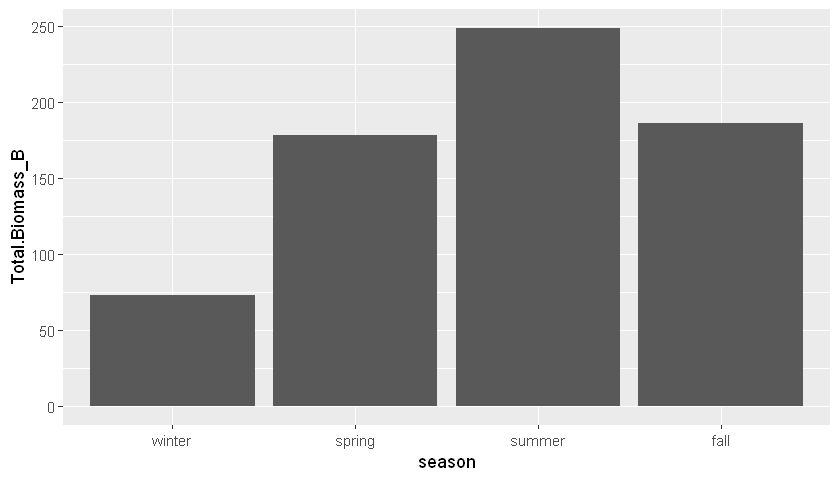

In [32]:
seasonal_B_summary2 = WW_Bdens_df %>%
    dplyr::select(,c(9,21:45,47:50)) %>%
    group_by(season) %>%
    summarise_all(.funs = funs(B = round(mean(., na.rm=TRUE),digits=2))) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


ggplot(seasonal_B_summary2, aes(y=Total.Biomass_B, x=season)) + 
#ggplot(seasonal_B_summary2, aes(y=PolychaetPelagic_B, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom")


In [33]:
seasonal_B_summary2[0:30]

season,yr_B,AmphiGam_B,AmphiHyp_B,BenthicLarv_B,CalCops.larg_B,CalCops.med_B,CalCops.smal_B,Cephalopoda_B,Chaetognatha_B,...,Other_B,PolychaetPelagic_B,Pteropods_B,Repantia_B,Scyphozoa_B,Siphonophorae_B,Total.Biomass_B,Total.Biomass.NoEuphs_B,Total.Biomass.Hard_B,Total.Biomass.Soft_B
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fall,2011.93,10.60,4.27,0.93,9.95,37.07,3.44,0.04,10.33,...,0.27,4.18,5.69,0.70,0.00,5.74,191.20,121.24,93.39,26.86
spring,2013.34,5.84,2.19,8.62,10.85,26.88,3.58,0.08,3.89,...,0.93,5.88,8.69,5.64,0.41,18.11,180.44,155.52,81.98,62.64
summer,2012.85,10.33,8.55,2.81,12.00,35.89,6.53,0.09,12.62,...,0.57,5.11,14.47,5.11,0.77,12.99,255.15,188.80,119.96,65.33
winter,2009.63,3.63,0.92,1.02,6.70,15.47,1.51,0.02,5.19,...,0.12,1.98,1.61,0.68,0.00,4.61,75.33,53.62,42.39,10.02


In [33]:
# TS by yr and mo
print("Summarize mean B by group, season and year")
yrmon_mean_df = WW_Bdens_df %>%
    dplyr::select(,c(9,10,21:45,47:49)) %>%
    group_by(yr,mon) %>%
    summarise_all(.funs = funs(B = round(mean(., na.rm=TRUE),digits=2))) 
head(yrmon_mean_df)

[1] "Summarize mean B by group, season and year"


yr,mon,AmphiGam_B,AmphiHyp_B,BenthicLarv_B,CalCops.larg_B,CalCops.med_B,CalCops.smal_B,Cephalopoda_B,Chaetognatha_B,Cladocera_B,Ctenophora_B,Euphs_B,Fish_B,Larvacea_B,Medusae_B,Mysids_B,Natantia_B,NonCalCops_B,Ostracoda_B,Other_B,PolychaetPelagic_B,Pteropods_B,Repantia_B,Scyphozoa_B,Siphonophorae_B,Total.Biomass_B,Total.Biomass.NoEuphs_B,Total.Biomass.Hard_B,Total.Biomass.Soft_B
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1996,2,3.42,0.43,0.06,34.62,20.22,0.88,0.12,0.65,0.01,0,9.11,0.04,0.1,2.50,0,0.49,0.34,3.91,0.58,3.40,1.22,0.00,0,9.09,91.21,82.10,69.60,12.40
1996,4,6.50,3.81,2.14,18.23,31.78,4.32,0.00,2.22,0.00,0,1.37,1.12,0.0,7.37,0,5.25,1.46,4.86,0.09,9.52,1.37,0.66,0,2.80,104.87,103.50,89.99,10.26
1997,1,7.51,1.74,0.10,12.24,27.78,0.71,0.00,13.26,0.00,0,9.79,0.00,0.0,1.10,0,0.28,0.70,2.51,0.00,5.65,0.67,0.00,0,1.58,85.62,75.83,73.05,2.68
1997,3,11.42,2.03,0.55,7.39,23.79,3.02,0.00,10.03,0.00,0,1.10,2.12,0.0,1.41,0,13.36,0.99,9.63,0.00,6.62,1.22,0.00,0,4.27,98.95,97.85,89.49,5.68
1997,4,1.88,0.42,0.20,1.29,4.51,0.57,0.00,1.01,0.00,0,10.81,0.53,0.0,0.64,0,0.22,0.23,1.15,0.00,1.62,0.65,0.10,0,0.32,26.15,15.34,13.65,0.96
1997,6,12.97,3.73,0.00,24.49,25.68,1.31,0.26,0.00,0.00,0,7.35,0.00,0.0,0.00,0,1.57,1.18,7.32,0.00,0.00,2.90,44.34,0,9.58,142.69,135.33,125.49,9.84


In [10]:
# haven't got this visual working yet
yrmon_mean_df %>%
    mutate(pd.to_datetime(df[['yr', 'mon']].assign(DAY=1))) + 
    ggplot( aes(x=yr, y=mean_B, group=group, color=group)) +
    theme(legend.position="bottom") +
    geom_line() + 
    scale_x_continuous(breaks = (seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), by = 2)))

ERROR: Error in parse(text = x, srcfile = src): <text>:3:44: unexpected symbol
2: yrmon_mean_df %>%
3:     mutate(pd.to_datetime(df[['yr', 'mon']].assign
                                              ^


In [34]:
B_yr_summary %>%
  #filter(group != "Total.Biomass_B_B") %>%
  filter(group == 'Total.Biomass.Hard_B_B' | group == 'Total.Biomass.Soft_B_B' |
        group == 'Euphs_B_B' | group == 'Fish_B_B' | group == 'Chaetognatha_B_B') %>%
  ggplot( aes(x=yr, y=mean_B, group=group, color=group)) +
  theme(legend.position="bottom") +
  geom_line() + 
  scale_x_continuous(breaks = (seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), by = 2)))

ERROR: Error in seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), : object 'seasonal_B_yr_summary' not found


In [14]:
B_yr_summary %>%
  #filter(group != "Total.Biomass_B_B") %>%
  filter(group == 'Fish_B_B') %>%
  ggplot( aes(x=yr, y=mean_B, group=group, color=group)) +
  theme(legend.position="bottom") +
  geom_line() + 
  scale_x_continuous(breaks = (seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), by = 2)))

ERROR: Error in seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), : object 'seasonal_B_yr_summary' not found


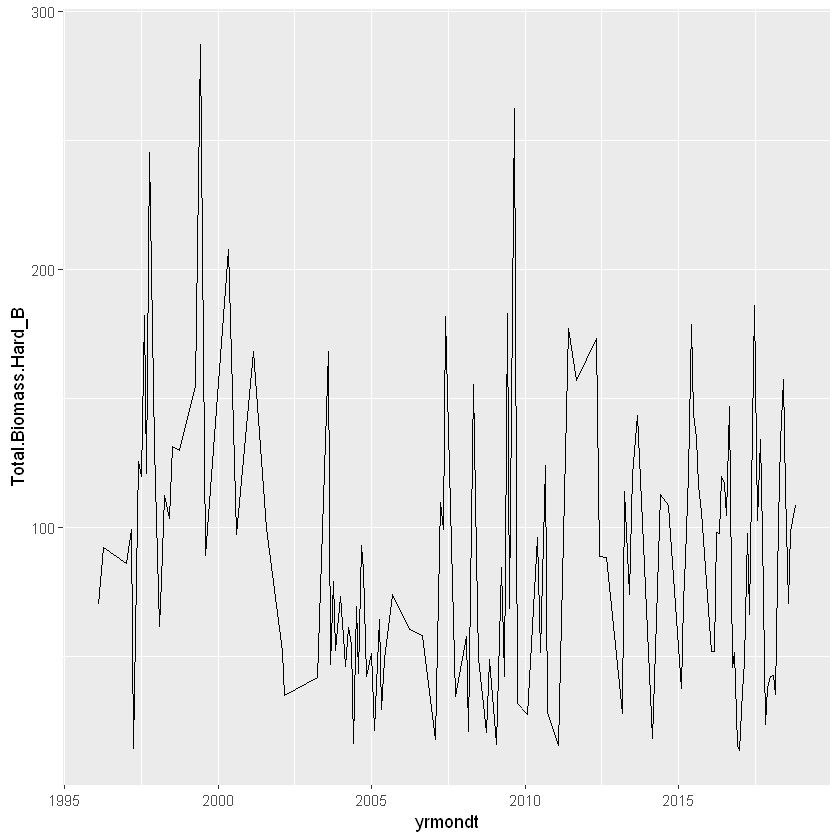

In [15]:
yrmon_mean_df$yrmondt = as.Date(paste(yrmon_mean_df$yr, yrmon_mean_df$mon,"01",sep="-"))

# i hate this plotting in ggplot and I don't understand how this actually works
yrmon_mean_df %>%
  ungroup() %>%
  select(c("Total.Biomass.Hard_B","Total.Biomass.Soft_B", "yrmondt")) %>%
  ggplot(aes(x=yrmondt, y=Total.Biomass.Hard_B)) +
  theme(legend.position="bottom") +
  geom_line() 
#+ 
 # scale_x_continuous(breaks = (seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), by = 2)))

Warning message:
"Removed 20 rows containing missing values (geom_path)."

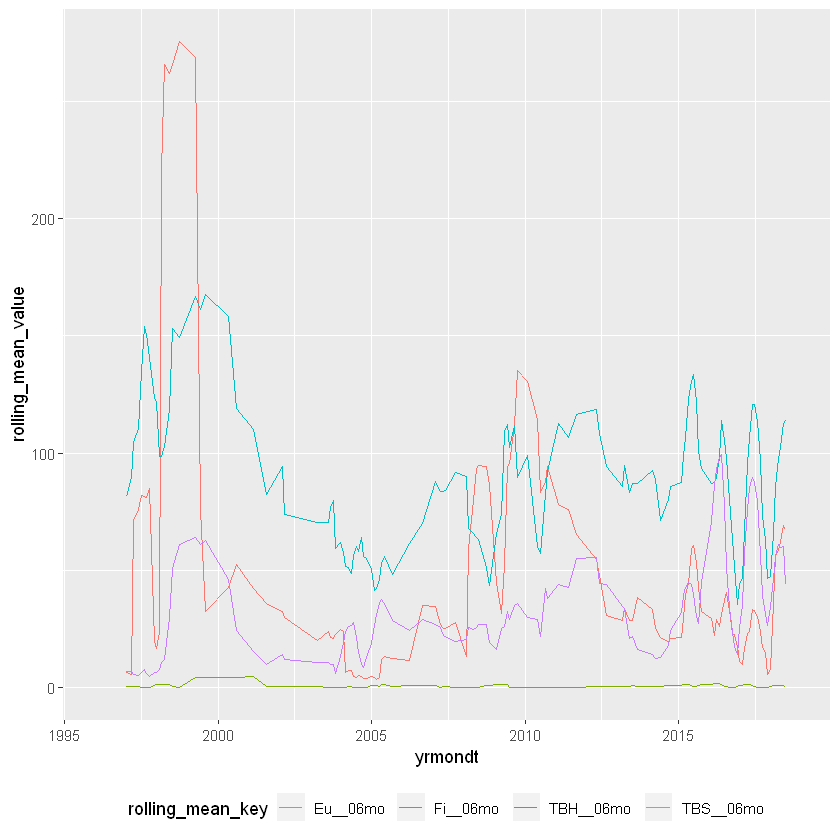

In [16]:
library(zoo) # moving averages

# to make this a nice chart remove / add groups

yrmon_mean_df %>%
    ungroup() %>%
    arrange(yrmondt) %>%
    select(c("Euphs_B","Fish_B","Total.Biomass.Hard_B","Total.Biomass.Soft_B", "yrmondt")) %>%
    dplyr::mutate(TBH_03mo = zoo::rollmean(Total.Biomass.Hard_B, k = 3, fill = NA),
                  TBH__06mo = zoo::rollmean(Total.Biomass.Hard_B, k = 6, fill = NA),
                  TBH__12mo = zoo::rollmean(Total.Biomass.Hard_B, k = 12, fill = NA),
                  TBS__03mo = zoo::rollmean(Total.Biomass.Soft_B, k = 3, fill = NA),
                  TBS__06mo = zoo::rollmean(Total.Biomass.Soft_B, k = 6, fill = NA),
                  TBS__12mo = zoo::rollmean(Total.Biomass.Soft_B, k = 12, fill = NA),
                  Eu__03mo = zoo::rollmean(Euphs_B, k = 3, fill = NA),
                  Eu__06mo = zoo::rollmean(Euphs_B, k = 6, fill = NA),
                  Eu__12mo = zoo::rollmean(Euphs_B, k = 12, fill = NA),
                  Fi__03mo = zoo::rollmean(Fish_B, k = 3, fill = NA),
                  Fi__06mo = zoo::rollmean(Fish_B, k = 6, fill = NA),
                  Fi__12mo = zoo::rollmean(Fish_B, k = 12, fill = NA)) %>% 
    pivot_longer(names_to = "rolling_mean_key", 
                 values_to = "rolling_mean_value",
                 cols = c(TBH__06mo,
                          TBS__06mo,
                          Eu__06mo,
                          Fi__06mo,
                         )) %>%
    ggplot(aes(x=yrmondt, y = rolling_mean_value, color = rolling_mean_key)) +
    theme(legend.position="bottom") +
    geom_line() 

Warning message:
"Removed 2 rows containing missing values (geom_point)."

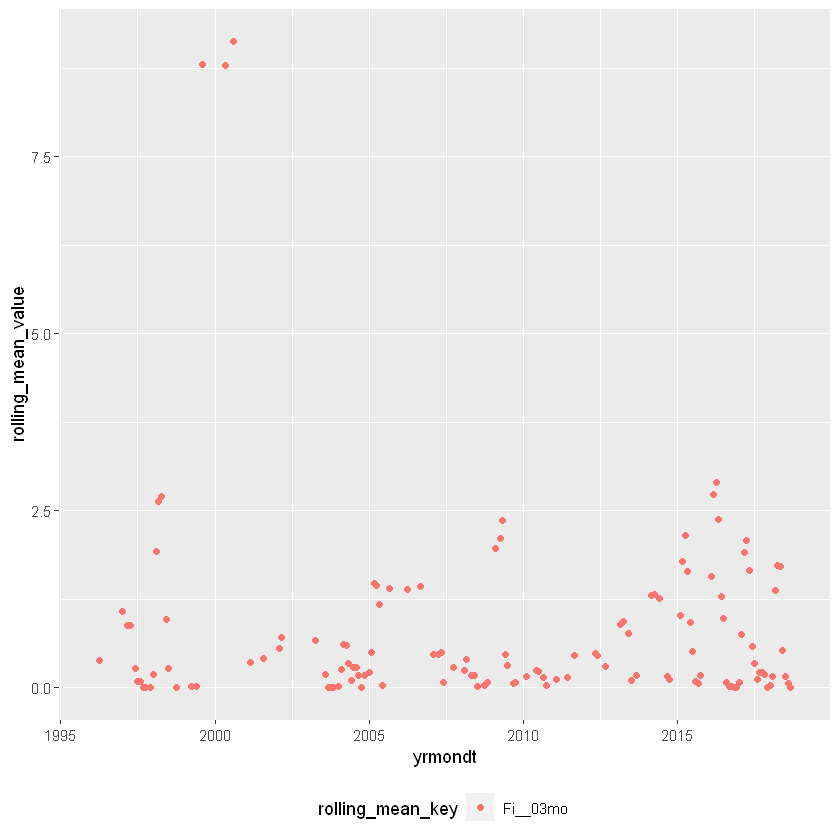

In [17]:
yrmon_mean_df %>%
    ungroup() %>%
    arrange(yrmondt) %>%
    select(c("Fish_B","yrmondt")) %>%
    dplyr::mutate(Fi__03mo = zoo::rollmean(Fish_B, k = 3, fill = NA),
                  Fi__06mo = zoo::rollmean(Fish_B, k = 6, fill = NA),
                  Fi__12mo = zoo::rollmean(Fish_B, k = 12, fill = NA)) %>% 
    pivot_longer(names_to = "rolling_mean_key", 
                 values_to = "rolling_mean_value",
                 cols = c(Fi__03mo,
                         )) %>%
    ggplot(aes(x=yrmondt, y = rolling_mean_value, color = rolling_mean_key)) +
    theme(legend.position="bottom") +
    geom_point() 

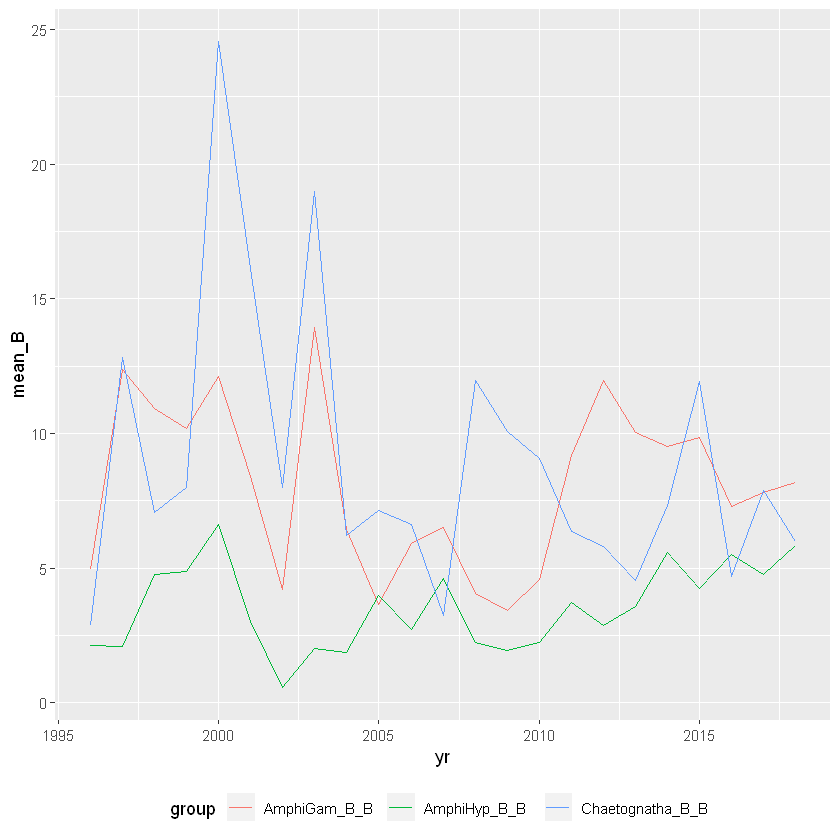

In [18]:
# to do: map to explore some distributions
# aggregate to match groups in EwE for TS
# create TS and export
B_yr_summary %>%
    filter(group == "AmphiGam_B_B" | group == "AmphiHyp_B_B" | group == "Chaetognatha_B_B") %>%
    ggplot(aes(x=yr, y = mean_B, color = group)) +
    theme(legend.position="bottom") +
    geom_line() 



## export time series

In [19]:
colnames(yrmon_mean_df)

[1] "yr"                      "mon"                    
 [3] "AmphiGam_B"              "AmphiHyp_B"             
 [5] "BenthicLarv_B"           "CalCops.larg_B"         
 [7] "CalCops.med_B"           "CalCops.smal_B"         
 [9] "Cephalopoda_B"           "Chaetognatha_B"         
[11] "Cladocera_B"             "Ctenophora_B"           
[13] "Euphs_B"                 "Fish_B"                 
[15] "Larvacea_B"              "Medusae_B"              
[17] "Mysids_B"                "Natantia_B"             
[19] "NonCalCops_B"            "Ostracoda_B"            
[21] "Other_B"                 "PolychaetPelagic_B"     
[23] "Pteropods_B"             "Repantia_B"             
[25] "Scyphozoa_B"             "Siphonophorae_B"        
[27] "Total.Biomass_B"         "Total.Biomass.NoEuphs_B"
[29] "Total.Biomass.Hard_B"    "Total.Biomass.Soft_B"   
[31] "yrmondt"

In [35]:
# pivot wider and export for EwE time series

ewe_ts = B_yr_summary %>%
    pivot_wider(names_from=group,values_from=mean_B) %>%
    mutate(Z1_ichthyomero = Fish_B_B) %>%
    mutate(Z2_Euphausiids = Euphs_B_B) %>%
    mutate(Z3_Amphipods_B = AmphiGam_B_B + AmphiHyp_B_B) %>%
    mutate(Z4_Chaet = Chaetognatha_B_B) %>%
    mutate(Z5_CopeLg = CalCops.larg_B_B) %>%
    mutate(Z6_CalCops_B = CalCops.med_B_B + CalCops.smal_B_B) %>%
    mutate(G4_Larvac = Larvacea_B_B) %>%
    mutate(G3_Ctenophora = Ctenophora_B_B) %>%
    mutate(G2_Medusae = Medusae_B_B)  %>%
    mutate(G1_Scyphozoa = Scyphozoa_B_B) 

write.csv(ewe_ts,paste(path_out_TS, "Perry2021_meanB_yr.csv", sep=""),row.names=FALSE)


#amphi_B_yr = B_yr_summary %>%
#    filter(group == "AmphiGam_B_B" | group == "AmphiHyp_B_B") %>%
#    group_by(yr) %>%
#    summarise(amphi_mean_B = round(sum(mean_B, na.rm=TRUE),digits=2))


# create time series for EwE
# monthly is possible but requires interpolating between missing months and adjusting
# for months with too few samples
#ts_f_amphi = "amphi_meanB_yr.csv"
#write.csv(amphi_B_yr,paste(path_out_TS,ts_f_amphi,sep=""),row.names=FALSE)

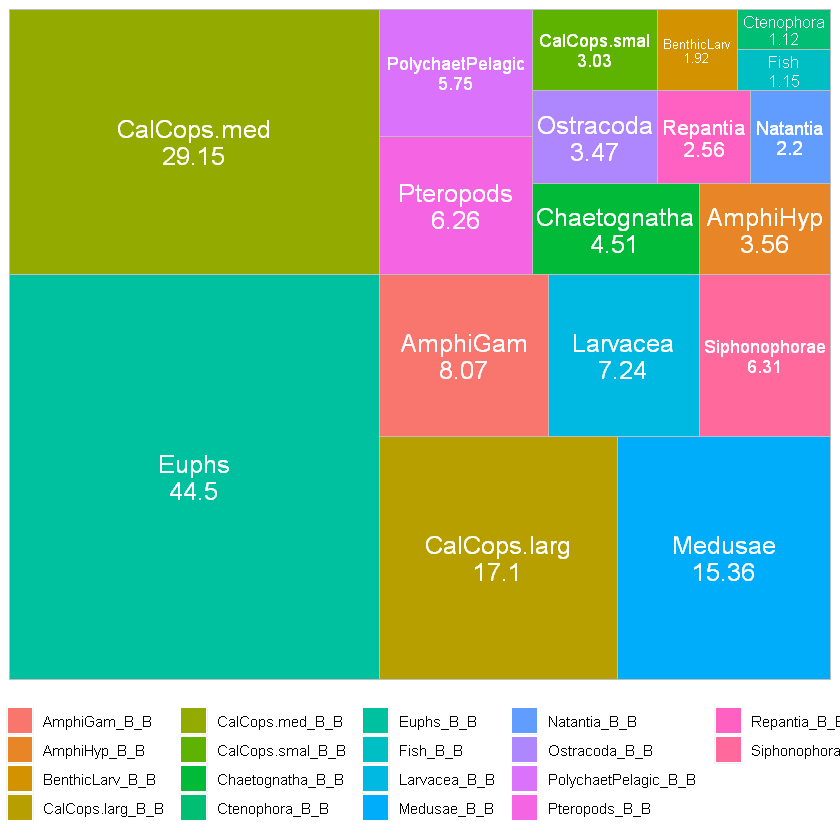

In [39]:
options(repr.plot.width=7, repr.plot.height=7)

yearround_B_avg %>%
    filter(group != "Total.Biomass_B_B" & group != "Total.Biomass.NoEuphs_B_B" & group != "Total.Biomass.Soft_B_B" & group != "Total.Biomass.Hard_B_B" & mean_B > 1) %>%
    ggplot(aes(area = mean_B, fill = group,label = paste(str_sub(group,1,nchar(group)-4),mean_B,sep="\n"))) +
    geom_treemap() + 
    geom_treemap_text(
         colour = "white",
         place = "center",
         size = 15) + theme(legend.position = "bottom")


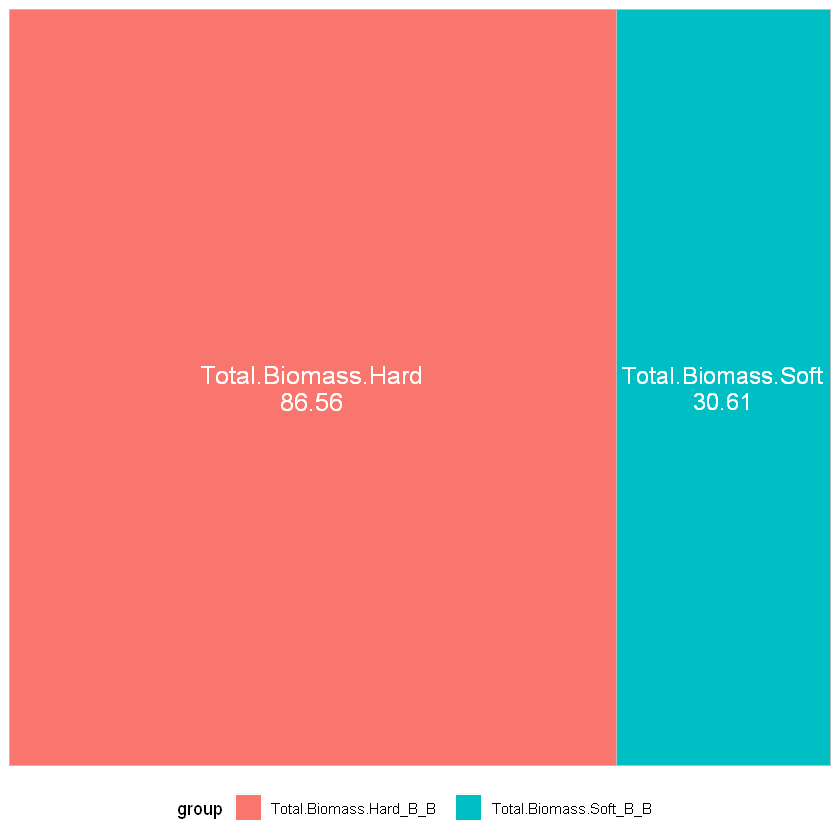

In [38]:
yearround_B_avg %>%
    filter(group == "Total.Biomass.Soft_B_B" | group == "Total.Biomass.Hard_B_B") %>%
    ggplot(aes(area = mean_B, fill = group,label = paste(str_sub(group,1,nchar(group)-4),mean_B,sep="\n"))) +
    geom_treemap() + 
    geom_treemap_text(
         colour = "white",
         place = "center",
         size = 15) + theme(legend.position = "bottom")

In [51]:
# basic meta stats on survey # etc
rows(WW_Bdens_df)

ERROR: Error in rows(WW_Bdens_df): could not find function "rows"


In [15]:
WW_Bdens_df %>% 
  group_by(yr) %>% 
  summarise(n = n())

`summarise()` ungrouping output (override with `.groups` argument)


yr,n
<int>,<int>
1996,4
1997,13
1998,20
1999,7
2000,4
2001,8
2002,9
2003,8
2004,27


# Section 2 - Un-aggregated Data Analysis
### explore dominant species of each functional group 

<br> raw downloaded from: https://open.canada.ca/data/en/dataset/2822c11d-6b6c-437e-ad65-85f584522adc
<br> Ian Perry, R., Young, K., Galbraith, M., Chandler, P., Velez-Espino, A., & Baillie, S. (2021). Zooplankton variability in the Strait of Georgia, Canada, and relationships with the marine survivals of Chinook and Coho salmon. PLoS ONE, 16(1 January), e0245941. https://doi.org/10.1371/journal.pone.0245941

<br> Note Jul 2022 - there is an issue where the Genus_species is repeated within individual tows (indexed by 'index')

In [84]:
# options for jupyter for display of rows / cols
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

# Boldt et al 2018 data shows mediocre year in 2000 for herring
# but Perry et al 2021 data show big year?? What species??
path = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//4. Zooplankton//Zoop_Perryetal_2021//MODIFIED//"
file = "Zoopl_SofG_1996-2018_EN_sizeclassesseparate.csv"
path_depths =  "C://Users//Greig//Documents//GitHub//Ecosystem-Model-Data-Framework//data//basemap//"
file_depths = "Depths_gt_zero_domain.csv"

df_2 <- read.csv(paste(path, file,sep=""))
df_depths <- read.csv(paste(path_depths, file_depths,sep=""))


# correspondence with I. Perry and K. Young Nov 16 2021
# - the mg m-2 is calculated using the tow start - end depth
# calculate the tow depth range
df_2['tow_depth_range'] = abs(df_2['Tow_start_depth.m.'])-abs(df_2['Tow_end_depth.m.'])
summary(df_2['tow_depth_range'])

# //////////////////////////////////////////////////////////////////////////////////
# net avoidance euphausiids adjust by 3x for adults
netavoid_x = 3

df_2 = df_2 %>%
    mutate(Abundance.m3. = case_when((size_class=="s3" & Order == "Euphausiacea") ~ Abundance.m3. * netavoid_x,
                                    TRUE ~ Abundance.m3.)) 

# cross-check
euphausiids = df_2 %>% filter(Order == "Euphausiacea")
colnames(euphausiids)
#arrange(euphausiids, desc(B_g_m2_DW), .by_group = FALSE)
print(unique(euphausiids$Genus_species))

# //////////////////////////////////////////////////////////////////////////////////
# create a season field
df_2 = df_2 %>%
    mutate(B_mg_m3_DW = Abundance.m3. * Average_biomass_per_individual.mg.) %>% # convert to mg m-3
    mutate(B_g_m2_DW = B_mg_m3_DW * tow_depth_range * mg_to_g) %>%  # mg m-3 to g m-2
    # not converting to WW B yet
    mutate(season = case_when(Month == 12 | Month == 1 | Month == 2 ~ "winter", 
                            Month == 3 | Month == 4 | Month == 5 ~ "spring", 
                            Month == 6 | Month == 7 | Month == 8 ~ "summer",  
                            Month == 9 | Month == 10 | Month == 11 ~ "fall")) 
nrow(df_2)

# Perry et al selected start depths with gt 150 m and  those with start depths <150 where 
# the tow depth range was gt 70% of the water column
df_2 = df_2 %>% 
  mutate(towrange_as_prop_watercol = tow_depth_range / Bottom_depth.m.) %>%
  filter(towrange_as_prop_watercol >= 0.7 | Tow_start_depth.m. >= 150)
nrow(df_2)
# seems like the filter above was already applied
#print("groups ordered by DW B")
#arrange(df_2, desc(B_g_m2_DW), .by_group = FALSE)


# //////////////////////////////////////////////////////////////////////////////////
# n_surveys used to avoid biasing density estimates using these presence-only data
# (absent species are not reported in these data)
n_surveys = n_distinct(df_2[c('Index')])
df_2$n_surveys = n_surveys
# table of surveys conducted per year
n_surveys_yr = df_2 %>% group_by(Year,Index) %>% 
    summarise(n = n()) %>%
    mutate(surveycount = 1) %>%
    ungroup() %>%
    group_by(Year) %>%
    summarise(count_surveys_yr = sum(surveycount))
df_2 = inner_join(df_2, n_surveys_yr, cols = "Year")
# per year  and season
n_surveys_yrseas = df_2 %>% group_by(Year,season,Index) %>% 
    summarise(n = n()) %>%
    mutate(surveycount = 1) %>%
    ungroup() %>%
    group_by(Year,season) %>%
    summarise(count_surveys_yrseas = sum(surveycount))
df_2 = inner_join(df_2, n_surveys_yrseas, cols = c("Year","season"))
colnames(df_2)

# //////////////////////////////////////////////////////////////////////////////////
# get average by YEAR and SEASON using taxa resoluation (size class)
print("YEAR, SEASON, summary nrow before")
nrow(df_2)
df_2_sizeclasslev = df_2 %>% 
    group_by(Year, season, Phylum,Class,Order,Family,Genus,Species,Genus_species,Size_class_or_life_stage,n_surveys,count_surveys_yr,count_surveys_yrseas) %>%
    summarise(B_mg_m3_DW = sum(round(B_mg_m3_DW, digits=2)),
          B_g_m2_DW = sum(round(B_g_m2_DW, digits=2)),
          Abundance.m3 = sum(round(Abundance.m3., digits=2)),
          AdultBody_size_mg = mean(round(Average_biomass_per_individual.mg., digits=2)),
          # n_occurrences is not used but summarizes how often the group appears in that season / year surveys
          n_occurrences = n()) %>%  
    # divide the sums from above by proper denominator (count of surveys done including zero abundance ones)
    mutate(B_mean_mg_m3_DW = round(B_mg_m3_DW / count_surveys_yrseas, digits=2)) %>%
    mutate(B_mean_g_m2_DW = round(B_g_m2_DW / count_surveys_yrseas, digits=2)) %>%
    distinct() %>%
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE)
print("nrow_after")
nrow(df_2_sizeclasslev)

# old way
# print("summarize by Genus_species instead of Size_class_or_life_stage")
# print("nrow before")
# nrow(df_2)
# df_2 = df_2 %>% 
#     group_by(Index, Station, Longitude..N., Latitude..W., Year, Month, Day, Time, season, Phylum,Class,Order,Family,Genus,Species,Genus_species,n_surveys,count_surveys_yr,count_surveys_yrseas) %>%
#     summarise(B_mg_m3_DW = sum(round(B_mg_m3_DW, digits=2)),
#           B_g_m2_DW = sum(round(B_g_m2_DW, digits=2)),
#           Abundance.m3 = sum(round(Abundance.m3., digits=2)),
#           AdultBody_size_mg = max(round(Average_biomass_per_individual.mg., digits=2))) 
# print("nrow_after")
# nrow(df_2)


# //////////////////////////////////////////////////////////////////////////////////
#  reduce to speices only by SUMMING b across all SIZE CLASSES (for each year and season)
df_2_seasyr_specieslev = df_2_sizeclasslev %>% 
    group_by(Year, season, Phylum,Class,Order,Family,Genus,Species,Genus_species,n_surveys,count_surveys_yr,count_surveys_yrseas) %>%
    summarise(B_mean_mg_m3_DW = sum(round(B_mean_mg_m3_DW, digits=2)),
          B_mean_g_m2_DW = sum(round(B_mean_g_m2_DW, digits=2)),
          Abundance_mean_m3 = sum(round(Abundance.m3, digits=2)),
          # want to use adults size class for reference so take max mean body size
          AdultBody_mean_size_mg = max(round(AdultBody_size_mg, digits=2))) %>%
      distinct() %>%
      arrange(desc(B_mean_g_m2_DW), .by_group = FALSE)
print("aggregating by species complete")

# ////////////////////////////////////////////////////////////////////
# label taxa by MODEL CODE and re-group
df_2_seasyr_specieslev$modelgroup = "misc"
df_2_seasyr_specieslev = df_2_seasyr_specieslev %>% 
    mutate(modelgroup = case_when((Phylum=="Chordata"& Class!="Appendicularia") ~ "ZF1-FIS",
                                  Phylum=="Cnidaria" & (Class=="Scyphozoa" | Family=="Aequoreidae") ~ "ZS1-JEL",
                                  Phylum=="Ctenophora" | (Phylum=="Cnidaria" & Class=="Hydrozoa" & Family!="Aequoreidae") ~ "ZS2-CTH",
                                  (Phylum=="Chaetognatha" | Class=="Polychaeta" | Class=="Gastropoda") ~ "ZS3-CHA",
                                  Class=="Appendicularia" ~ "ZS4-LAR",
                                  (Order=="Calanoida" | Order=="Cyclopoida" | Class=="Ostracoda") & AdultBody_mean_size_mg < 0.201 ~ "ZC5-CSM",
                                  (Order=="Calanoida" | Order=="Oithona") & AdultBody_mean_size_mg > 0.2 ~ "ZC4-CLG",
                                  (Order=="Decapoda" | Order=="Thecostraca") ~ "ZC3-DEC",
                                  Order=="Amphipoda"  ~ "ZC2-AMP",
                                  Order=="Euphausiacea" ~ "ZC1-EUP",
                                  TRUE ~ "misc"
                                 )
           ) %>% 
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE)
print("completed modelgroup labels")


# ////////////////////////////////////////////////////////////////////
# convert DW to WET WEIGHT 

df_2_seasyr_specieslev$B_mean_g_m2_WW = 0
df_2_seasyr_specieslev$B_mean_mg_m3_WW = 0
df_2_seasyr_specieslev = df_2_seasyr_specieslev %>% 
    mutate(B_mean_g_m2_WW = case_when(modelgroup=="ZC1-EUP" ~ DW_to_WW_ZC1_EUP * B_mean_g_m2_DW,
                                  modelgroup=="ZC2-AMP" ~ DW_to_WW_ZC2_AMP * B_mean_g_m2_DW,
                                  modelgroup=="ZC3-DEC" ~ DW_to_WW_ZC3_DEC * B_mean_g_m2_DW,
                                  modelgroup=="ZC4-CLG" ~ DW_to_WW_ZC4_CLG * B_mean_g_m2_DW,
                                  modelgroup=="ZC5-CSM" ~ DW_to_WW_ZC5_CSM * B_mean_g_m2_DW,
                                  modelgroup=="ZS1-JEL" ~ DW_to_WW_ZG1_JEL * B_mean_g_m2_DW,
                                  modelgroup=="ZS2-CTH" ~ DW_to_WW_ZG2_CTH * B_mean_g_m2_DW,
                                  modelgroup=="ZS3-CHA" ~ DW_to_WW_ZG3_CHA * B_mean_g_m2_DW,
                                  modelgroup=="ZS4-LAR" ~ DW_to_WW_ZG4_LAR * B_mean_g_m2_DW,
                                  modelgroup=="ZF1-FIS" ~ DW_to_WW_ZF1_FIS * B_mean_g_m2_DW,
                                  # else default
                                  TRUE ~ DW_to_WW_zoop * B_mean_g_m2_DW
                                 )
           ) %>% 
    mutate(B_mean_mg_m3_WW = case_when(modelgroup=="ZC1-EUP" ~ DW_to_WW_ZC1_EUP * B_mean_mg_m3_DW,
                                  modelgroup=="ZC2-AMP" ~ DW_to_WW_ZC2_AMP * B_mean_mg_m3_DW,
                                  modelgroup=="ZC3-DEC" ~ DW_to_WW_ZC3_DEC * B_mean_mg_m3_DW,
                                  modelgroup=="ZC4-CLG" ~ DW_to_WW_ZC4_CLG * B_mean_mg_m3_DW,
                                  modelgroup=="ZC5-CSM" ~ DW_to_WW_ZC5_CSM * B_mean_mg_m3_DW,
                                  modelgroup=="ZS1-JEL" ~ DW_to_WW_ZG1_JEL * B_mean_mg_m3_DW,
                                  modelgroup=="ZS2-CTH" ~ DW_to_WW_ZG2_CTH * B_mean_mg_m3_DW,
                                  modelgroup=="ZS3-CHA" ~ DW_to_WW_ZG3_CHA * B_mean_mg_m3_DW,
                                  modelgroup=="ZS4-LAR" ~ DW_to_WW_ZG4_LAR * B_mean_mg_m3_DW,
                                  modelgroup=="ZF1-FIS" ~ DW_to_WW_ZF1_FIS * B_mean_mg_m3_DW,
                                  # else default
                                  TRUE ~ DW_to_WW_zoop * B_mean_mg_m3_DW
                                 )
           ) %>% 
    arrange(desc(B_mean_g_m2_WW), .by_group = FALSE)
print("wet wet calculations complete")

# //////////////////////////////////////////////////////////////////////////////////
# summary across all YEARS - at species level, not modelgroup level

# how many years of data?
yearsdf = df_2_seasyr_specieslev %>% ungroup() %>% summarize(max_yr = max(Year),
                                                  min_yr = min(Year))
years = yearsdf$max_yr - yearsdf$min_yr
df_2_summary = df_2_seasyr_specieslev %>% 
    group_by(season,Phylum,Class,Order,Family,Genus,Species,Genus_species,modelgroup) %>%
    summarise(B_sum_g_m2_DW = sum(round(B_mean_g_m2_DW, digits=2)),
              B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
              B_sum_mg_m3_DW = sum(round(B_mean_mg_m3_DW, digits=2)),
              B_sum_mg_m3_WW = sum(round(B_mean_mg_m3_WW, digits=2)),
          AdultBody_size_mg_mean = mean(round(AdultBody_mean_size_mg, digits=2)),
          n = n_surveys,
          # n occurrences just used for cross checks
          n_occurrences = n()) %>%
    mutate(B_mean_g_m2_DW = round(B_sum_g_m2_DW / years, digits=2)) %>%
    mutate(B_mean_g_m2_WW = round(B_sum_g_m2_WW / years, digits=2)) %>%
    mutate(B_mean_mg_m3_DW = round(B_sum_mg_m3_DW / years, digits=2)) %>%
    mutate(B_mean_mg_m3_WW = round(B_sum_mg_m3_WW / years, digits=2)) %>%
    distinct() %>%
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE)

# df_2_summary

# adjust this for compat with code below
df_2_yrseas_mean = df_2_seasyr_specieslev
df_2_yrseas_mean$AdultBody_size_mg_mean =  df_2_yrseas_mean$AdultBody_mean_size_mg
print("seasonal summary across years complete")

# ////////////////////////////////////////////////////////////////////
# cross check stats on what groups are uncategorized
#missing gastropods (mollusc; Limacina.helicina,Clione.limacina), fish

df_2_summary %>% 
  group_by(modelgroup) %>% 
  summarize(mean = mean(B_mean_g_m2_DW),
            sum = sum(B_mean_g_m2_DW)) %>%
    arrange(desc(sum), .by_group = FALSE)

df_2_summary %>% 
  filter(modelgroup == "misc") %>%
  group_by(Genus_species) %>% 
  summarize(mean = mean(B_mean_g_m2_DW),
            sum = sum(B_mean_g_m2_DW)) %>%
    arrange(desc(sum), .by_group = FALSE)

# ////////////////////////////////////////////////////////////////////
# sum by group within season
# get average by modelgroup over seasons

 temp1 = df_2_summary %>%
    group_by(season,modelgroup) %>%
    summarise(B_mean_g_m2_DW = sum(round(B_mean_g_m2_DW, digits=2)),
             B_mean_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
             B_mean_mg_m3_DW = sum(round(B_mean_mg_m3_DW, digits=2)),
             B_mean_mg_m3_WW = sum(round(B_mean_mg_m3_WW, digits=2))) %>%
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))
print("averaging all b across seasons...")

n_seasons = 4
avg_B_modelgroups = temp1 %>%
    group_by(modelgroup) %>%
    summarise(B_sum_g_m2_DW = sum(round(B_mean_g_m2_DW, digits=2)),
             B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
             B_sum_mg_m3_DW = sum(round(B_mean_mg_m3_DW, digits=2)),
             B_sum_mg_m3_WW = sum(round(B_mean_mg_m3_WW, digits=2))) %>%
    mutate(B_mean_g_m2_DW = round(B_sum_g_m2_DW / n_seasons, digits=2)) %>%
    mutate(B_mean_g_m2_WW = round(B_sum_g_m2_WW / n_seasons, digits=2)) %>%
    mutate(B_mean_mg_m3_DW = round(B_sum_mg_m3_DW / n_seasons, digits=2)) %>%
    mutate(B_mean_mg_m3_WW = round(B_sum_mg_m3_WW / n_seasons, digits=2)) %>%
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE) 


# ////////////////////////////////////////////////////////////////////
# attempt to adjust for spatial sampling biases (see text)

# ////////////////////////////////////////////////////////////////////
# calc tow depth range percent of column on average
# shoudl probably be seasonally stratified but this is quick and just a rough est
avg_tow_depth_perc = df_2 %>% select(Index, tow_depth_range, Bottom_depth.m.) %>% 
    mutate(tow_depth_range_per = tow_depth_range / Bottom_depth.m.) %>% 
    distinct() %>% 
    summarise(n = n(),
             tow_depth_range_per_avg = mean(tow_depth_range_per)) %>% 
    pull(tow_depth_range_per_avg)

# ////////////////////////////////////////////////////////////////////
# adjust for over-estimation due to deep water bias in samples
# get annual total avg conc
ZC1_EUP_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZC1-EUP") %>% pull(B_mean_mg_m3_WW)
ZC2_AMP_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZC2-AMP") %>% pull(B_mean_mg_m3_WW)
ZC3_DEC_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZC3-DEC") %>% pull(B_mean_mg_m3_WW)
ZC4_CLG_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZC4-CLG") %>% pull(B_mean_mg_m3_WW)
ZC5_CSM_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZC5-CSM") %>% pull(B_mean_mg_m3_WW)

ZS1_JEL_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZS1-JEL") %>% pull(B_mean_mg_m3_WW)
ZS2_CTH_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZS2-CTH") %>% pull(B_mean_mg_m3_WW)
ZS3_CHA_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZS3-CHA") %>% pull(B_mean_mg_m3_WW)
ZS4_LAR_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZS4-LAR") %>% pull(B_mean_mg_m3_WW)

ZF1_FIS_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "ZF1-FIS") %>% pull(B_mean_mg_m3_WW)
misc_mg_m3_avg = avg_B_modelgroups %>% filter(modelgroup == "misc") %>% pull(B_mean_mg_m3_WW)

df_depths$ZC1_EUP = 0
df_depths$ZC2_AMP = 0
df_depths$ZC3_DEC = 0
df_depths$ZC4_CLG = 0
df_depths$ZC5_CSM = 0

df_depths$ZS1_JEL = 0
df_depths$ZS2_CTH = 0
df_depths$ZS3_CHA = 0
df_depths$ZS4_LAR = 0

df_depths$ZF1_FIS = 0
df_depths$misc = 0

avg_B_WW_modelgroups_better = df_depths %>%
    mutate(ZC1_EUP = depth * avg_tow_depth_perc * ZC1_EUP_mg_m3_avg * mg_to_g) %>%
    mutate(ZC2_AMP = depth * avg_tow_depth_perc * ZC2_AMP_mg_m3_avg * mg_to_g) %>%
    mutate(ZC3_DEC = depth * avg_tow_depth_perc * ZC3_DEC_mg_m3_avg * mg_to_g) %>%
    mutate(ZC4_CLG = depth * avg_tow_depth_perc * ZC4_CLG_mg_m3_avg * mg_to_g) %>%
    mutate(ZC5_CSM = depth * avg_tow_depth_perc * ZC5_CSM_mg_m3_avg * mg_to_g) %>%
    mutate(ZS1_JEL = depth * avg_tow_depth_perc * ZS1_JEL_mg_m3_avg * mg_to_g) %>%
    mutate(ZS2_CTH = depth * avg_tow_depth_perc * ZS2_CTH_mg_m3_avg * mg_to_g) %>%
    mutate(ZS3_CHA = depth * avg_tow_depth_perc * ZS3_CHA_mg_m3_avg * mg_to_g) %>%
    mutate(ZS4_LAR = depth * avg_tow_depth_perc * ZS4_LAR_mg_m3_avg * mg_to_g) %>%
    mutate(ZF1_FIS = depth * avg_tow_depth_perc * ZF1_FIS_mg_m3_avg * mg_to_g) %>%
    mutate(misc = depth * misc_mg_m3_avg * mg_to_g) %>%
    summarise(ZC1_EUP = round(mean(ZC1_EUP),digits=1),
             ZC2_AMP = round(mean(ZC2_AMP),digits=1),
             ZC3_DEC = round(mean(ZC3_DEC),digits=1),
             ZC4_CLG = round(mean(ZC4_CLG),digits=1),
             ZC5_CSM = round(mean(ZC5_CSM),digits=1),
             ZS1_JEL = round(mean(ZS1_JEL),digits=1),
             ZS2_CTH = round(mean(ZS2_CTH),digits=1),
             ZS3_CHA = round(mean(ZS3_CHA),digits=1),
             ZS4_LAR = round(mean(ZS4_LAR),digits=1),
             ZF1_FIS = round(mean(ZF1_FIS),digits=1),
             misc = round(mean(misc),digits=1)) %>%
    pivot_longer(everything(), names_to = "modelgroup", values_to = "B_mean_g_m2_WW")

# ////////////////////////////////////////////////////////////////////
# convert back from WW to DW
avg_B_WW_modelgroups_better$B_mean_g_m2_DW = 0
avg_B_WW_modelgroups_better = avg_B_WW_modelgroups_better %>% 
    mutate(B_mean_g_m2_DW = case_when(modelgroup=="ZC1_EUP" ~ B_mean_g_m2_WW / DW_to_WW_ZC1_EUP,
                                      modelgroup=="ZC2_AMP" ~ B_mean_g_m2_WW / DW_to_WW_ZC2_AMP,
                                      modelgroup=="ZC3_DEC" ~ B_mean_g_m2_WW / DW_to_WW_ZC3_DEC,
                                      modelgroup=="ZC4_CLG" ~ B_mean_g_m2_WW / DW_to_WW_ZC4_CLG,
                                      modelgroup=="ZC5_CSM" ~ B_mean_g_m2_WW / DW_to_WW_ZC5_CSM,
                                      modelgroup=="ZS1_JEL" ~ B_mean_g_m2_WW / DW_to_WW_ZG1_JEL,
                                      modelgroup=="ZS2_CTH" ~ B_mean_g_m2_WW / DW_to_WW_ZG2_CTH,
                                      modelgroup=="ZS3_CHA" ~ B_mean_g_m2_WW / DW_to_WW_ZG3_CHA,
                                      modelgroup=="ZS4_LAR" ~ B_mean_g_m2_WW / DW_to_WW_ZG4_LAR,
                                      modelgroup=="ZF1_FIS" ~ B_mean_g_m2_WW / DW_to_WW_ZF1_FIS,
                                      modelgroup=="misc" ~ B_mean_g_m2_WW / DW_to_WW_zoop,
                                      # else default
                                      TRUE ~ B_mean_g_m2_WW / DW_to_WW_zoop
                                 ))


avg_B_WW_modelgroups_better

# ////////////////////////////////////////////////////////////////////
# adjust for over-estimation due to deep water bias in samples
# seasonal avg by species
# ////////////////////////////////////////////////////////////////////
# convert back from WW to DW at seasonal and species level
# df_2_summary
# using actual depths across domain get actual B using m3 conc
df_depths <- read.csv(paste(path_depths, file_depths,sep=""))

get_avg_depth_int <- function(m3) {
    m2 = df_depths %>%
    mutate(m2_int = depth * avg_tow_depth_perc * m3 * mg_to_g) %>%
    summarise(m2_int_avg = round(mean(m2_int),digits=2)) %>% 
    pull(m2_int_avg)
    return(m2)
}

df_2_summary <- df_2_summary %>% rowwise() %>%
  mutate(adj_DW_g_m2 = get_avg_depth_int(B_mean_mg_m3_DW)) %>%
  mutate(adj_WW_g_m2 = get_avg_depth_int(B_mean_mg_m3_WW))
df_2_summary

 tow_depth_range
 Min.   : 48.0  
 1st Qu.:231.0  
 Median :290.0  
 Mean   :277.2  
 3rd Qu.:344.0  
 Max.   :420.0  

[1] "Index"                              "Region"                            
 [3] "Station"                            "Longitude..N."                     
 [5] "Latitude..W."                       "Year"                              
 [7] "Month"                              "Day"                               
 [9] "Time"                               "Twilight"                          
[11] "Net_type"                           "Net_Diameter.m."                   
[13] "Mesh_size.µm."                      "Tow_start_depth.m."                
[15] "Tow_end_depth.m."                   "Bottom_depth.m."                   
[17] "Volume.m3."                         "Phylum"                            
[19] "Class"                              "Order"                             
[21] "Family"                             "Genus"                             
[23] "Species"                            "Genus_species"                     
[25] "Size_class_or_life_stage"           "size_class"                        
[27] "Abundance.m3."                      "Average_biomass_per_individual.mg."
[29] "tow_depth_range"

 [1] Euphausia.pacifica       Thysanoessa.longipes     Euphausiidae.*sp.       
 [4] Thysanoessa.spinifera    Thysanoessa.raschii      Nematoscelis.difficilis 
 [7] Thysanoessa.inspinata    Nematoscelis.*sp.        Thysanoessa.inermis     
[10] Tessarabrachion.oculatum Thysanoessa.*sp.         Euphausiacea.*sp.       
442 Levels: Acantharia.*sp. Acartia.*sp. ... Xenacanthomysis.pseudomacropsis


[1] 81544

[1] 81544

`summarise()` regrouping output by 'Year' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
Joining, by = "Year"
`summarise()` regrouping output by 'Year', 'season' (override with `.groups` argument)
`summarise()` regrouping output by 'Year' (override with `.groups` argument)
Joining, by = c("Year", "season")


[1] "Index"                              "Region"                            
 [3] "Station"                            "Longitude..N."                     
 [5] "Latitude..W."                       "Year"                              
 [7] "Month"                              "Day"                               
 [9] "Time"                               "Twilight"                          
[11] "Net_type"                           "Net_Diameter.m."                   
[13] "Mesh_size.µm."                      "Tow_start_depth.m."                
[15] "Tow_end_depth.m."                   "Bottom_depth.m."                   
[17] "Volume.m3."                         "Phylum"                            
[19] "Class"                              "Order"                             
[21] "Family"                             "Genus"                             
[23] "Species"                            "Genus_species"                     
[25] "Size_class_or_life_stage"           "size_class"                        
[27] "Abundance.m3."                      "Average_biomass_per_individual.mg."
[29] "tow_depth_range"                    "B_mg_m3_DW"                        
[31] "B_g_m2_DW"                          "season"                            
[33] "towrange_as_prop_watercol"          "n_surveys"                         
[35] "count_surveys_yr"                   "count_surveys_yrseas"

[1] "YEAR, SEASON, summary nrow before"


[1] 81544

`summarise()` regrouping output by 'Year', 'season', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Genus_species', 'Size_class_or_life_stage', 'n_surveys', 'count_surveys_yr' (override with `.groups` argument)


[1] "nrow_after"


[1] 14952

`summarise()` regrouping output by 'Year', 'season', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Genus_species', 'n_surveys', 'count_surveys_yr' (override with `.groups` argument)


[1] "aggregating by species complete"
[1] "completed modelgroup labels"
[1] "wet wet calculations complete"


`summarise()` regrouping output by 'season', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Genus_species', 'modelgroup' (override with `.groups` argument)


[1] "seasonal summary across years complete"


`summarise()` ungrouping output (override with `.groups` argument)


modelgroup,mean,sum
<chr>,<dbl>,<dbl>
ZC4-CLG,0.196829268,16.14
ZC5-CSM,0.046377358,12.29
ZC2-AMP,0.151718750,9.71
ZC1-EUP,0.274117647,9.32
ZS3-CHA,0.044098361,5.38
ZS2-CTH,0.019115646,2.81
ZC3-DEC,0.015158730,1.91
ZS4-LAR,0.045263158,0.86
ZF1-FIS,0.005185185,0.56


`summarise()` ungrouping output (override with `.groups` argument)


Genus_species,mean,sum
<fct>,<dbl>,<dbl>
Alacia.pseudoalata,0.020000000,0.08
Triconia.borealis,0.015000000,0.06
Corycaeus.anglicus,0.012500000,0.05
Microniscus.*sp.,0.012500000,0.05
Bryozoa.*sp.,0.007500000,0.03
Noctiluca.*sp.,0.006666667,0.02
Gonatus.*sp.,0.002500000,0.01
Podon.*sp.,0.002500000,0.01
Acantharia.*sp.,0.000000000,0.00


`summarise()` regrouping output by 'season' (override with `.groups` argument)


[1] "averaging all b across seasons..."


`summarise()` ungrouping output (override with `.groups` argument)


modelgroup,B_mean_g_m2_WW,B_mean_g_m2_DW
<chr>,<dbl>,<dbl>
ZC1_EUP,10.5,1.40000000
ZC2_AMP,4.8,1.20000000
ZC3_DEC,2.6,0.26000000
ZC4_CLG,9.2,1.84000000
ZC5_CSM,10.6,1.51428571
ZS1_JEL,0.7,0.02800000
ZS2_CTH,9.8,0.36981132
ZS3_CHA,6.8,0.68000000
ZS4_LAR,3.3,0.13200000


season,Phylum,Class,Order,Family,Genus,Species,Genus_species,modelgroup,B_sum_g_m2_DW,B_sum_g_m2_WW,B_sum_mg_m3_DW,B_sum_mg_m3_WW,AdultBody_size_mg_mean,n,n_occurrences,B_mean_g_m2_DW,B_mean_g_m2_WW,B_mean_mg_m3_DW,B_mean_mg_m3_WW,adj_DW_g_m2,adj_WW_g_m2
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
summer,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,72.24,541.83,342.61,2569.57,7.9680000,760,20,3.28,24.63,15.57,116.80,2.14,16.03
fall,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,65.64,492.30,283.72,2127.91,8.5000000,760,17,2.98,22.38,12.90,96.72,1.77,13.27
spring,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,61.69,308.45,219.98,1099.90,0.6014286,760,21,2.80,14.02,10.00,50.00,1.37,6.86
summer,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,55.88,223.52,198.27,793.08,5.7000000,760,20,2.54,10.16,9.01,36.05,1.24,4.95
summer,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,54.88,384.16,198.49,1389.43,0.1400000,760,20,2.49,17.46,9.02,63.16,1.24,8.67
fall,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,46.90,187.60,160.75,643.00,5.7000000,760,18,2.13,8.53,7.31,29.23,1.00,4.01
summer,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,45.55,227.75,141.22,706.10,0.5545000,760,20,2.07,10.35,6.42,32.10,0.88,4.41
fall,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,42.68,213.40,128.13,640.65,0.5552941,760,17,1.94,9.70,5.82,29.12,0.80,4.00
spring,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,41.14,287.98,147.08,1029.56,0.1400000,760,21,1.87,13.09,6.69,46.80,0.92,6.42


In [322]:
# df_2 %>% filter(season=="fall" & Year==1997 & Species=="plumchrus")
# df_2_temp %>% filter(Year == 1998 & Order == "Euphausiacea" & season=="summer")

In [495]:
# cross chekcing WW DW conversions
avg_B_modelgroups$crosscheckconversions = avg_B_modelgroups$B_mean_g_m2_WW / avg_B_modelgroups$B_mean_g_m2_DW 
avg_B_modelgroups

modelgroup,B_sum_g_m2_DW,B_sum_g_m2_WW,B_mean_g_m2_DW,B_mean_g_m2_WW,crosscheckconversions
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZC4-CLG,16.14,80.94,4.04,20.23,5.007426
ZC5-CSM,12.29,86.70,3.07,21.68,7.061889
ZC2-AMP,9.71,39.00,2.43,9.75,4.012346
ZC1-EUP,9.32,70.11,2.33,17.53,7.523605
ZS3-CHA,5.38,54.35,1.34,13.59,10.141791
ZS2-CTH,2.81,75.90,0.70,18.98,27.114286
ZC3-DEC,1.91,19.56,0.48,4.89,10.187500
ZS4-LAR,0.86,21.84,0.22,5.46,24.818182
ZF1-FIS,0.56,2.98,0.14,0.74,5.285714


In [497]:
print("Dry Weight B total")
avg_B_modelgroups %>% ungroup() %>% summarise(sum_B_DW = sum(B_mean_g_m2_DW))

print("Wet Weight B total")
avg_B_modelgroups %>% ungroup() %>% summarise(sum_B_WW = sum(B_mean_g_m2_WW))

[1] "Dry Weight B total"


sum_B_DW
<dbl>
14.87


[1] "Wet Weight B total"


sum_B_WW
<dbl>
114.66


In [ ]:
df_2_summary

In [161]:
print("how many samples night")
t = df_2_summary %>%
 group_by(season) %>%
 summarise(adj_WW_g_m2 = sum(adj_WW_g_m2))
t 

[1] "how many samples night"


`summarise()` ungrouping output (override with `.groups` argument)


season,adj_WW_g_m2
<chr>,<dbl>
fall,57.87
spring,67.48
summer,90.68
winter,20.13


## Survey summary stats for methods

In [496]:
print("how many samples night")
t = df_2 %>%
 group_by(Index, Twilight) %>%
 summarise() 
t %>% ungroup() %>% count(Twilight, sort = TRUE)

[1] "how many samples night"


`summarise()` regrouping output by 'Index' (override with `.groups` argument)


Twilight,n
<fct>,<int>
Daylight,635
Night,125


In [471]:
print("net types")
t = df_2 %>%
 group_by(Index, Net_type) %>%
 summarise() 
t %>% ungroup() %>% count(Net_type, sort = TRUE)

[1] "net types"


`summarise()` regrouping output by 'Index' (override with `.groups` argument)


Net_type,n
<fct>,<int>
SCOR VNH,383
Bongo VNH,363
Ring VNH,14


In [472]:
print("net types")
t = df_2 %>%
 group_by(Index, Net_type) %>%
 summarise() 
t %>% ungroup() %>% count(Net_type, sort = TRUE)

[1] "net types"


`summarise()` regrouping output by 'Index' (override with `.groups` argument)


Net_type,n
<fct>,<int>
SCOR VNH,383
Bongo VNH,363
Ring VNH,14


In [473]:
print("tow depths")
t = df_2 %>%
 group_by(Index, Tow_start_depth.m.) %>%
 summarise() 

t %>% ungroup() %>% summarise(mean=mean(Tow_start_depth.m.), 
                             max=max(Tow_start_depth.m.),
                             min=min(Tow_start_depth.m.))

[1] "tow depths"


`summarise()` regrouping output by 'Index' (override with `.groups` argument)


mean,max,min
<dbl>,<int>,<int>
268.5368,420,48


In [474]:
print("mesh sizes")
t = df_2 %>%
 group_by(Index, Mesh_size.µm.) %>%
 summarise() 

t %>% ungroup() %>% summarise(mean=mean(Mesh_size.µm.), 
                             max=max(Mesh_size.µm.),
                             min=min(Mesh_size.µm.))

[1] "mesh sizes"


`summarise()` regrouping output by 'Index' (override with `.groups` argument)


mean,max,min
<dbl>,<int>,<int>
239.0974,335,200


In [44]:
df_2$tow_depth_range_prop = df_2$tow_depth_range / df_2$Bottom_depth.m.

In [ ]:
print("net types")
t = df_2 %>%
 group_by(Index, Net_type) %>%
 summarise() 
t %>% ungroup() %>% count(Net_type, sort = TRUE)

In [314]:
print("mesh sizes")
t = df_2 %>%
 group_by(Index, Net_Diameter.m.) %>%
 summarise() 

t %>% ungroup() %>% summarise(mean=mean(Net_Diameter.m.), 
                             max=max(Net_Diameter.m.),
                             min=min(Net_Diameter.m.))

[1] "mesh sizes"


`summarise()` regrouping output by 'Index' (override with `.groups` argument)


mean,max,min
<dbl>,<dbl>,<dbl>
0.5602895,0.58,0.5


In [317]:
print("samples by season")
t = df_2 %>%
 group_by(Index, season) %>%
 summarise() 

t %>% ungroup() %>% count(season)

[1] "samples by season"


`summarise()` regrouping output by 'Index' (override with `.groups` argument)


season,n
<chr>,<int>
fall,163
spring,275
summer,239
winter,83


In [159]:
df_2_summary

season,Phylum,Class,Order,Family,Genus,Species,Genus_species,modelgroup,B_sum_g_m2_DW,B_sum_g_m2_WW,B_sum_mg_m3_DW,B_sum_mg_m3_WW,AdultBody_size_mg_mean,n,n_occurrences,B_mean_g_m2_DW,B_mean_g_m2_WW,B_mean_mg_m3_DW,B_mean_mg_m3_WW,adj_DW_g_m2,adj_WW_g_m2
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
summer,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,72.24,541.83,342.61,2569.57,7.9680000,760,20,3.28,24.63,15.57,116.80,2.14,16.03
fall,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,65.64,492.30,283.72,2127.91,8.5000000,760,17,2.98,22.38,12.90,96.72,1.77,13.27
spring,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,61.69,308.45,219.98,1099.90,0.6014286,760,21,2.80,14.02,10.00,50.00,1.37,6.86
summer,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,55.88,223.52,198.27,793.08,5.7000000,760,20,2.54,10.16,9.01,36.05,1.24,4.95
summer,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,54.88,384.16,198.49,1389.43,0.1400000,760,20,2.49,17.46,9.02,63.16,1.24,8.67
fall,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,46.90,187.60,160.75,643.00,5.7000000,760,18,2.13,8.53,7.31,29.23,1.00,4.01
summer,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,45.55,227.75,141.22,706.10,0.5545000,760,20,2.07,10.35,6.42,32.10,0.88,4.41
fall,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,42.68,213.40,128.13,640.65,0.5552941,760,17,1.94,9.70,5.82,29.12,0.80,4.00
spring,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,41.14,287.98,147.08,1029.56,0.1400000,760,21,1.87,13.09,6.69,46.80,0.92,6.42


In [492]:
df_2_summary %>% filter(modelgroup=="ZF1-FIS")

df_2_summary %>% filter(modelgroup=="ZF1-FIS") %>% ungroup() %>% 
    summarise(mean_size = mean(AdultBody_size_mg_mean) * )

season,Phylum,Class,Order,Family,Genus,Species,Genus_species,modelgroup,B_sum_g_m2_DW,B_sum_g_m2_WW,AdultBody_size_mg_mean,n,n_occurrences,B_mean_g_m2_DW,B_mean_g_m2_WW
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
spring,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,ZF1-FIS,5.22,34.77,19.0900000,760,4,0.24,1.58
spring,Chordata,Actinopterygii,Gadiformes,Merlucciidae,Merluccius,productus,Merluccius.productus,ZF1-FIS,2.44,16.25,4.6157895,760,19,0.11,0.74
spring,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Leuroglossus,schmidti,Leuroglossus.schmidti,ZF1-FIS,1.00,6.66,14.1031579,760,19,0.05,0.30
spring,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,ZF1-FIS,0.80,5.33,6.8700000,760,9,0.04,0.24
spring,Chordata,Actinopterygii,Pleuronectiformes,Pleuronectidae,Lyopsetta,exilis,Lyopsetta.exilis,ZF1-FIS,0.62,4.12,6.3125000,760,8,0.03,0.19
spring,Chordata,Actinopterygii,Actinopterygii,Actinopterygii,Fish,*sp.,Fish.*sp.,ZF1-FIS,0.37,2.46,5.6330769,760,13,0.02,0.11
spring,Chordata,Actinopterygii,Clupeiformes,Clupeiformes,Clupeiformes,*sp.,Clupeiformes.*sp.,ZF1-FIS,0.50,3.33,2.6940000,760,5,0.02,0.15
spring,Chordata,Actinopterygii,Gadiformes,Gadidae,Theragra,chalcogramma,Theragra.chalcogramma,ZF1-FIS,0.25,1.66,2.8083333,760,12,0.01,0.08
spring,Chordata,Actinopterygii,Scorpaeniformes,Scorpaenidae,Sebastes,*sp.,Sebastes.*sp.,ZF1-FIS,0.17,1.13,3.0375000,760,12,0.01,0.05


mean_size
<dbl>
6.545719


In [299]:
colnames(df_2)

[1] "Index"                              "Region"                            
 [3] "Station"                            "Longitude..N."                     
 [5] "Latitude..W."                       "Year"                              
 [7] "Month"                              "Day"                               
 [9] "Time"                               "Twilight"                          
[11] "Net_type"                           "Net_Diameter.m."                   
[13] "Mesh_size.µm."                      "Tow_start_depth.m."                
[15] "Tow_end_depth.m."                   "Bottom_depth.m."                   
[17] "Volume.m3."                         "Phylum"                            
[19] "Class"                              "Order"                             
[21] "Family"                             "Genus"                             
[23] "Species"                            "Genus_species"                     
[25] "Size_class_or_life_stage"           "size_class"                        
[27] "Abundance.m3."                      "Average_biomass_per_individual.mg."
[29] "tow_depth_range"                    "B_mg_m3_DW"                        
[31] "B_g_m2_DW"                          "season"                            
[33] "towrange_as_prop_watercol"          "n_surveys"                         
[35] "count_surveys_yr"                   "count_surveys_yrseas"

## Treemaps of total b 

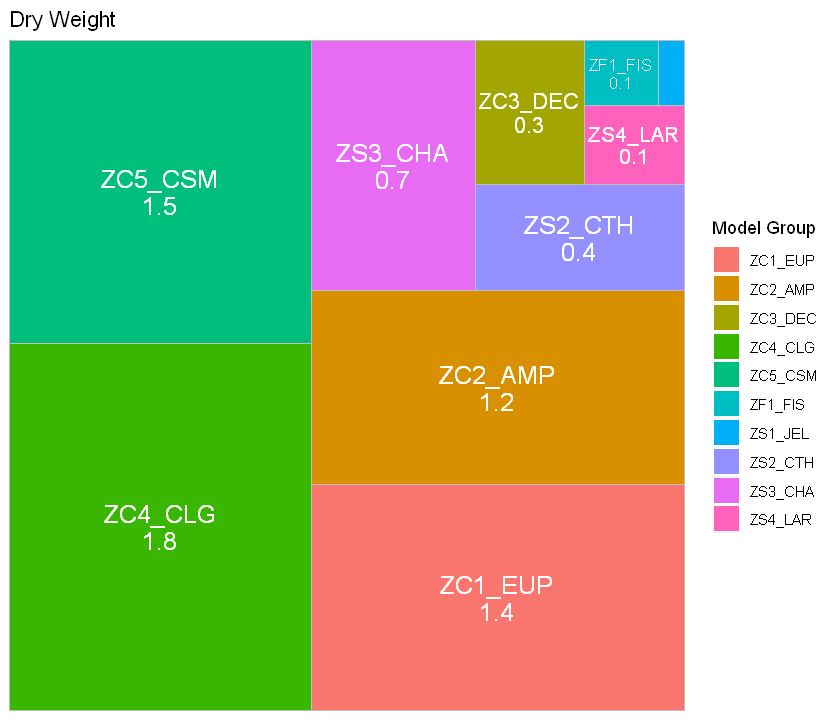

In [33]:
options(repr.plot.width=7, repr.plot.height=6)

avg_B_WW_modelgroups_better %>%

    filter(B_mean_g_m2_WW > 0.01 & modelgroup != "misc") %>%
    ggplot(aes(area = B_mean_g_m2_DW, fill = modelgroup, label = paste(modelgroup,round(B_mean_g_m2_DW,digits=1),sep="\n"))) +
    geom_treemap() + 
    geom_treemap_text(
         colour = "white",
         place = "center",
         size = 15) + #theme(legend.position = "bottom") + 
        labs(title="Dry Weight", fill = "Model Group") 

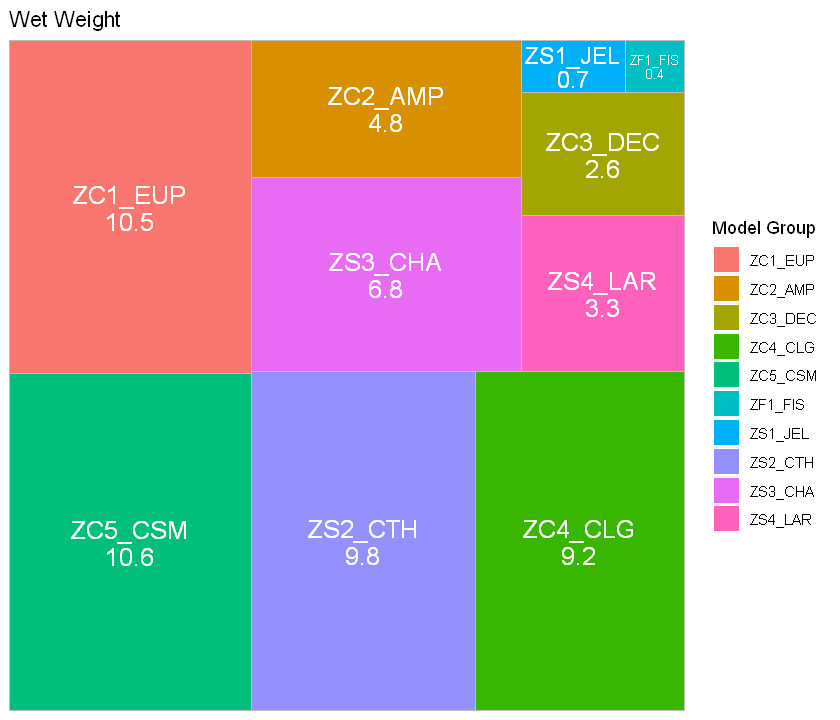

In [35]:
options(repr.plot.width=7, repr.plot.height=6)

avg_B_WW_modelgroups_better %>%

    filter(B_mean_g_m2_WW > 0.01 & modelgroup != "misc") %>%
    ggplot(aes(area = B_mean_g_m2_WW, fill = modelgroup, label = paste(modelgroup,round(B_mean_g_m2_WW,digits=1),sep="\n"))) +
    geom_treemap() + 
    geom_treemap_text(
         colour = "white",
         place = "center",
         size = 15) + theme(legend.position = "right") + 
        labs(title="Wet Weight", fill = "Model Group")

In [39]:
print("B summary")
t = avg_B_WW_modelgroups_better %>%
 summarise(B_mean_g_m2_WW = sum(B_mean_g_m2_WW),
          B_mean_g_m2_DW = sum(B_mean_g_m2_DW)) 

t

[1] "B summary"


B_mean_g_m2_WW,B_mean_g_m2_DW
<dbl>,<dbl>
59.1,7.564157


## Fish

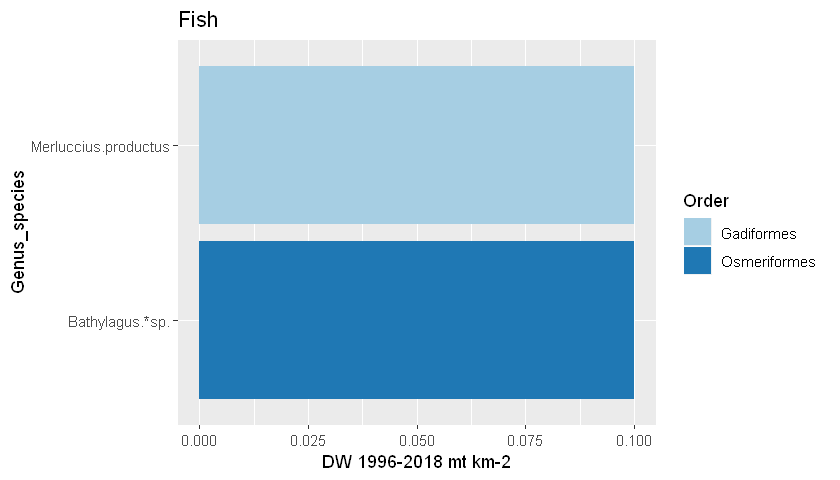

In [74]:
options(repr.plot.width=7, repr.plot.height=4)

# fish Phylum Chordata
#df_2 %>% filter(Phylum=="Chordata")
df_2_summary_fish = df_2_summary %>% 
                    arrange(desc(adj_DW_g_m2)) %>% 
                    filter(Phylum=="Chordata" & adj_DW_g_m2 >= 2.034211e-10 & 
                          Class!="Appendicularia")

# Basic barplot
p<-ggplot(data=df_2_summary_fish, 
          aes(x=reorder(Genus_species,adj_DW_g_m2), 
              y=adj_DW_g_m2, 
              fill=Order)) +
    geom_bar(stat="identity") +
    scale_fill_brewer(palette="Paired") +
    labs(title="Fish", x="Genus_species", y="DW 1996-2018 mt km-2")
# note https://www.r-graph-gallery.com/38-rcolorbrewers-palettes.html

# Horizontal bar plot
p + coord_flip()

# Leuroglossus schmidti = Northern Smoothtongue
# Bathylagus milleri  = deep sea smelt / owlfish / 
# Merluccius productus = hake


## Chaetognaths

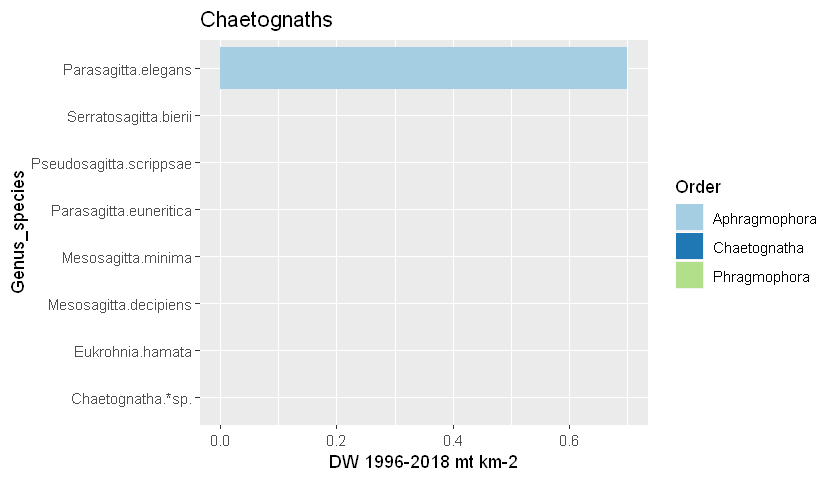

In [75]:
options(repr.plot.width=7, repr.plot.height=4)

#df_2 %>% filter(Phylum=="Chordata")
df_2_summary_chaet = df_2_summary %>% 
                    arrange(desc(adj_DW_g_m2)) %>% 
                    filter(Phylum=="Chaetognatha" & 
                          Class!="Appendicularia")

# Basic barplot
p<-ggplot(data=df_2_summary_chaet, 
          aes(x=reorder(Genus_species,adj_DW_g_m2), 
              y=adj_DW_g_m2, 
              fill=Order)) +
    geom_bar(stat="identity") +
    scale_fill_brewer(palette="Paired") +
    labs(title="Chaetognaths", x="Genus_species", y="DW 1996-2018 mt km-2")
# note https://www.r-graph-gallery.com/38-rcolorbrewers-palettes.html

# Horizontal bar plot
p + coord_flip()

# Leuroglossus schmidti = Northern Smoothtongue
# Bathylagus milleri  = deep sea smelt / owlfish / 
# Merluccius productus = hake

## Larvaceans / Appendicularian

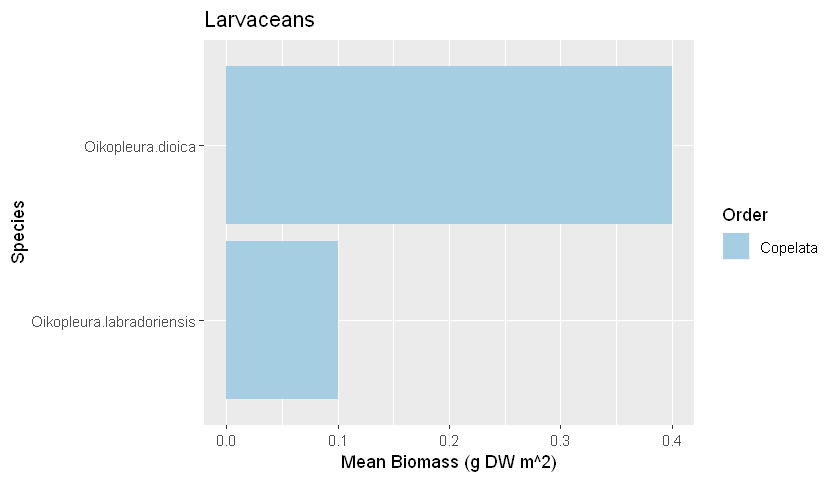

In [76]:
options(repr.plot.width=7, repr.plot.height=4)

df_2_summary_larvac = df_2_summary %>% 
                    arrange(desc(adj_DW_g_m2)) %>% 
                    filter(Class=="Appendicularia" & adj_DW_g_m2 >= 2.034211e-06)

# Basic barplot
p<-ggplot(data=df_2_summary_larvac, 
          aes(x=reorder(Genus_species,adj_DW_g_m2), 
              y=adj_DW_g_m2, 
              fill=Order)) +
    geom_bar(stat="identity") +
    scale_fill_brewer(palette="Paired") +
    labs(title="Larvaceans", x="Species", y="Mean Biomass (g DW m^2)")
# note https://www.r-graph-gallery.com/38-rcolorbrewers-palettes.html

# Horizontal bar plot
p + coord_flip()

# Leuroglossus schmidti = Northern Smoothtongue
# Bathylagus milleri  = deep sea smelt / owlfish / 
# Merluccius productus = hake

## All Cnidarians

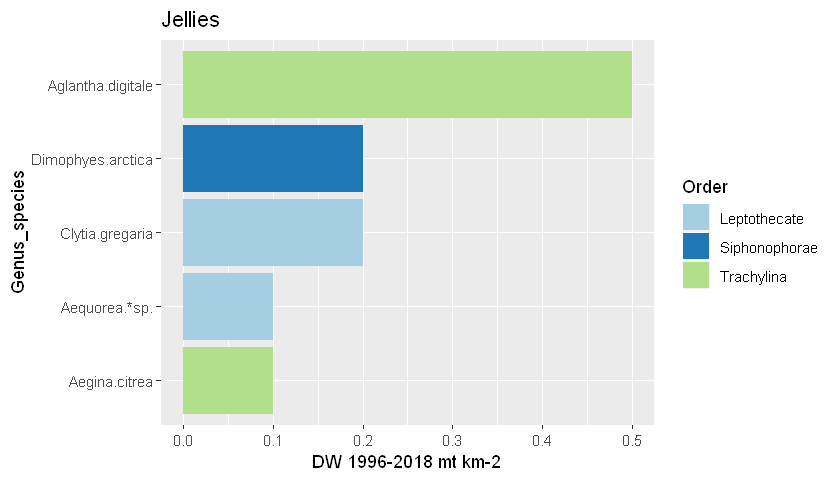

In [77]:
df_2_summary_jelly = df_2_summary %>% 
                    arrange(desc(adj_DW_g_m2)) %>% 
                    filter(Phylum=="Cnidaria" & adj_DW_g_m2 >= 2.034211e-02)

# Basic barplot
p<-ggplot(data=df_2_summary_jelly, 
          aes(x=reorder(Genus_species,adj_DW_g_m2), 
              y=adj_DW_g_m2, 
              fill=Order)) +
    geom_bar(stat="identity") +
    scale_fill_brewer(palette="Paired") +
    labs(title="Jellies", x="Genus_species", y="DW 1996-2018 mt km-2")
# note https://www.r-graph-gallery.com/38-rcolorbrewers-palettes.html

# Horizontal bar plot
p + coord_flip()

# Leuroglossus schmidti = Northern Smoothtongue
# Bathylagus milleri  = deep sea smelt / owlfish / 
# Merluccius productus = hake

## Ctenophores & Cnidarians by size class

### did not work - explored data and decided 'big' is Scyphozoa and a single Family of Hydrozoa (Aequoreidae), small is all others

season,Phylum,Class,Order,Family,Genus,Species,Genus_species,modelgroup,B_sum_g_m2_DW,B_sum_g_m2_WW,B_sum_mg_m3_DW,B_sum_mg_m3_WW,AdultBody_size_mg_mean,n,n_occurrences,B_mean_g_m2_DW,B_mean_g_m2_WW,B_mean_mg_m3_DW,B_mean_mg_m3_WW,adj_DW_g_m2,adj_WW_g_m2
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
summer,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,72.24,541.83,342.61,2569.57,7.9680000,760,20,3.28,24.63,15.57,116.80,2.1,16.0
fall,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,65.64,492.30,283.72,2127.91,8.5000000,760,17,2.98,22.38,12.90,96.72,1.8,13.3
spring,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,61.69,308.45,219.98,1099.90,0.6014286,760,21,2.80,14.02,10.00,50.00,1.4,6.9
summer,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,55.88,223.52,198.27,793.08,5.7000000,760,20,2.54,10.16,9.01,36.05,1.2,4.9
summer,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,54.88,384.16,198.49,1389.43,0.1400000,760,20,2.49,17.46,9.02,63.16,1.2,8.7
fall,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,46.90,187.60,160.75,643.00,5.7000000,760,18,2.13,8.53,7.31,29.23,1.0,4.0
summer,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,45.55,227.75,141.22,706.10,0.5545000,760,20,2.07,10.35,6.42,32.10,0.9,4.4
fall,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,42.68,213.40,128.13,640.65,0.5552941,760,17,1.94,9.70,5.82,29.12,0.8,4.0
spring,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,41.14,287.98,147.08,1029.56,0.1400000,760,21,1.87,13.09,6.69,46.80,0.9,6.4


## ZS1-JEL - Large Jellies

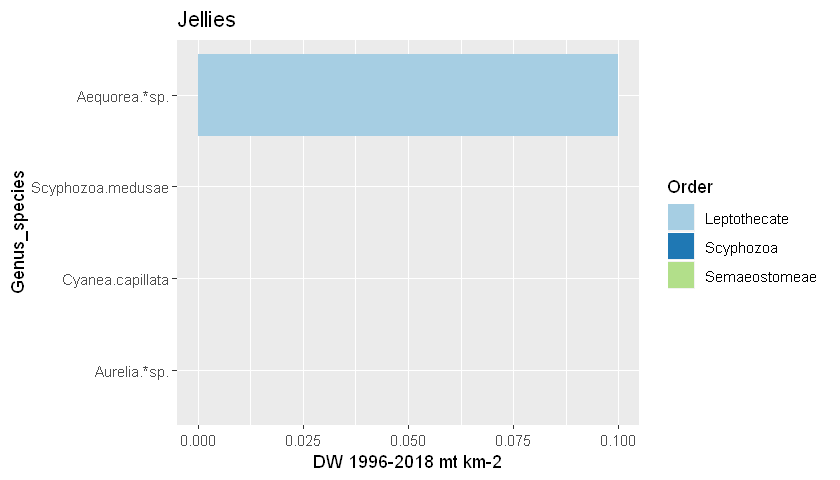

In [78]:
df_2_summary_jelly = df_2_summary %>% 
                    arrange(desc(adj_DW_g_m2)) %>% 
                    filter(Phylum=="Cnidaria" & (Class =="Scyphozoa" | Family == "Aequoreidae"))

# Basic barplot
p<-ggplot(data=df_2_summary_jelly, 
          aes(x=reorder(Genus_species,adj_DW_g_m2), 
              y=adj_DW_g_m2, 
              fill=Order)) +
    geom_bar(stat="identity") +
    scale_fill_brewer(palette="Paired") +
    labs(title="Jellies", x="Genus_species", y="DW 1996-2018 mt km-2")
# note https://www.r-graph-gallery.com/38-rcolorbrewers-palettes.html

# Horizontal bar plot
p + coord_flip()

# Leuroglossus schmidti = Northern Smoothtongue
# Bathylagus milleri  = deep sea smelt / owlfish / 
# Merluccius productus = hake

## Ctenophores

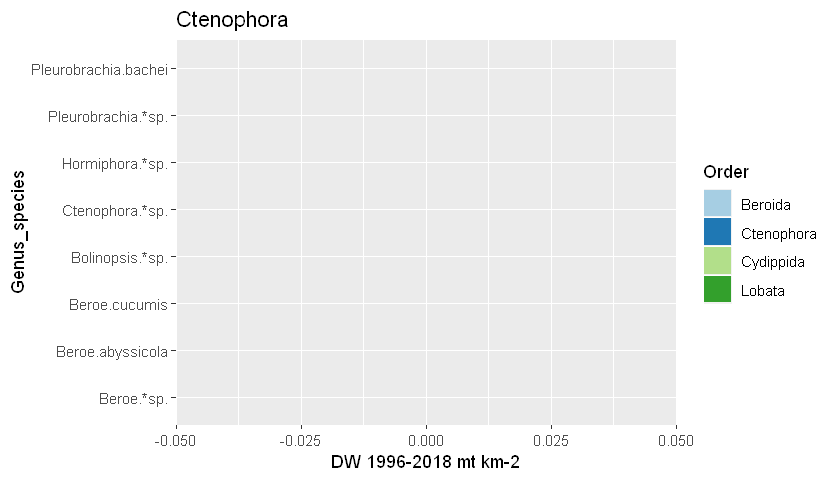

In [81]:
df_2_summary_cteno = df_2_summary %>% 
                    arrange(desc(adj_DW_g_m2)) %>% 
                    filter(Phylum=="Ctenophora" )

# Basic barplot
p<-ggplot(data=df_2_summary_cteno, 
          aes(x=reorder(Genus_species,adj_DW_g_m2), 
              y=adj_DW_g_m2, 
              fill=Order)) +
    geom_bar(stat="identity") +
    scale_fill_brewer(palette="Paired") +
    labs(title="Ctenophora", x="Genus_species", y="DW 1996-2018 mt km-2")
# note https://www.r-graph-gallery.com/38-rcolorbrewers-palettes.html

# Horizontal bar plot
p + coord_flip()

# Leuroglossus schmidti = Northern Smoothtongue
# Bathylagus milleri  = deep sea smelt / owlfish / 
# Merluccius productus = hake

## Time series by year

In [296]:
colnames(df_2)

[1] "Index"             "Station"           "Longitude..N."    
 [4] "Latitude..W."      "Year"              "Month"            
 [7] "Day"               "Time"              "Phylum"           
[10] "Class"             "Order"             "Family"           
[13] "Genus"             "Species"           "Genus_species"    
[16] "B_mg_m3_DW"        "B_g_m2_DW"         "Abundance.m3"     
[19] "AdultBody_size_mg"

In [181]:
# Summary by year mean
df_2_yr_mean = df_2 %>% 
    group_by(Year,Phylum,Class,Order,Family,Genus,Species,Genus_species) %>%
    #group_by(Class,Order) %>%
    # summing here because of presence-only bias
    summarise(B_sum_g_m2_DW = sum(round(B_g_m2_DW, digits=2)),
          AdultBody_size_mg_mean = mean(round(AdultBody_size_mg, digits=2)),
          n_surv_yr = mean(count_surveys_yr), # i have to use a function here, mean is fine (same value after)
          n_occurrences_yr = n()) %>%
    mutate(B_mean_g_m2_DW = round(B_sum_g_m2_DW, digits=2) / n_occurrences_yr) %>%
    distinct() %>%
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE)
    
df_2_yr_mean

`summarise()` regrouping output by 'Year', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species' (override with `.groups` argument)


Year,Phylum,Class,Order,Family,Genus,Species,Genus_species,B_sum_g_m2_DW,AdultBody_size_mg_mean,n_surv_yr,n_occurrences_yr,B_mean_g_m2_DW
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2000,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,10.44,76.30000000,4,1,10.440000
1997,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,115.05,0.58461538,13,13,8.850000
2011,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,49.87,0.56500000,9,6,8.311667
1998,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,111.90,7.84066667,20,15,7.460000
2000,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,29.70,0.55000000,4,4,7.425000
1999,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,51.70,0.55000000,7,7,7.385714
2008,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,188.87,8.50000000,30,26,7.264231
2012,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,70.68,0.55000000,17,14,5.048571
2001,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,34.89,0.49714286,8,7,4.984286


## Appendicularian Time Series 

`summarise()` ungrouping output (override with `.groups` argument)


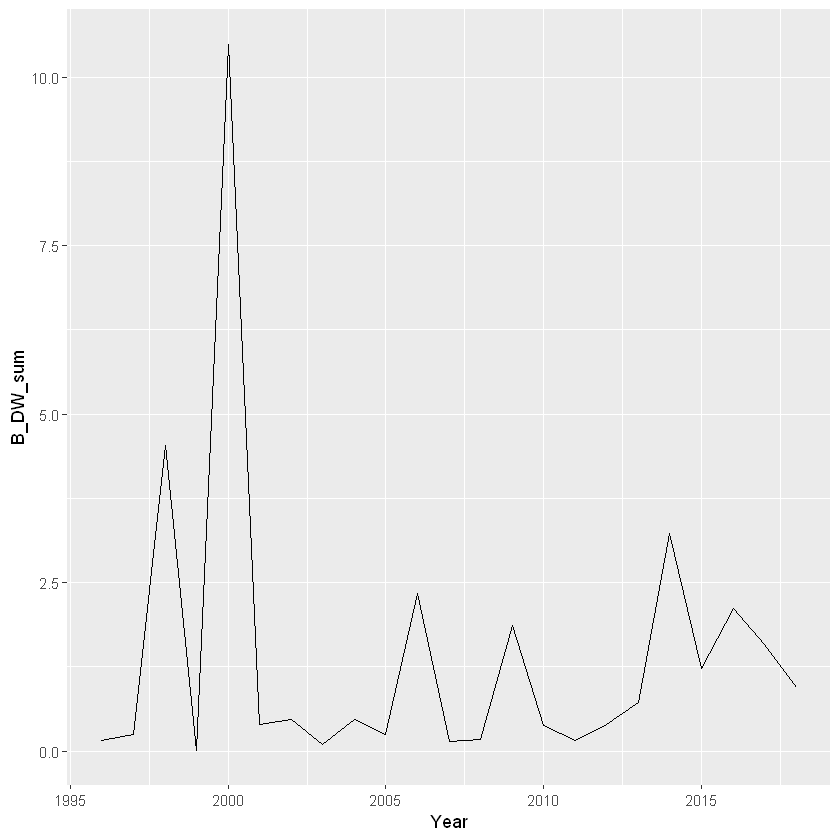

In [30]:
df_2_yr_mean_fish = df_2_yr_mean %>%
    filter(Phylum=="Chordata" & Class!="Appendicularia")
    #filter(Genus_species == "Leuroglossus.schmidti")
    #dplyr::mutate(Fi__03mo = zoo::rollmean(Fish_B, k = 3, fill = NA),
    #              Fi__06mo = zoo::rollmean(Fish_B, k = 6, fill = NA),
    #              Fi__12mo = zoo::rollmean(Fish_B, k = 12, fill = NA)) %>% 
    #pivot_longer(names_to = "rolling_mean_key", 
    #             values_to = "rolling_mean_value",
    #             cols = c(Fi__03mo,
    #                     )) %>%


df_2_yr_mean_allfishtogether = df_2_yr_mean_fish %>%
    group_by(Year) %>%
    summarise(B_DW_sum = sum(round(B_mean_g_m2_DW, digits=6)))

ggplot(data=df_2_yr_mean_allfishtogether,aes(x=Year, y = B_DW_sum)) +
    theme(legend.position="bottom") +
    geom_line() 

## Euphausiidae time series

`summarise()` ungrouping output (override with `.groups` argument)


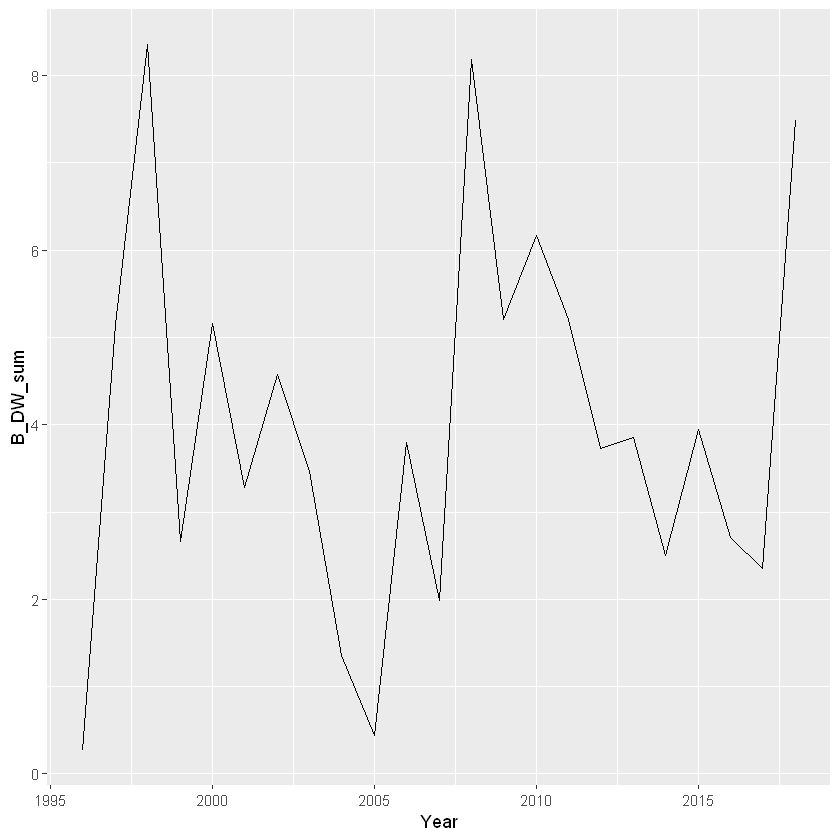

In [31]:
df_2_yr_mean_euph = df_2_yr_mean %>%
    filter(Family=="Euphausiidae")
    #filter(Genus_species == "Leuroglossus.schmidti")
    #dplyr::mutate(Fi__03mo = zoo::rollmean(Fish_B, k = 3, fill = NA),
    #              Fi__06mo = zoo::rollmean(Fish_B, k = 6, fill = NA),
    #              Fi__12mo = zoo::rollmean(Fish_B, k = 12, fill = NA)) %>% 
    #pivot_longer(names_to = "rolling_mean_key", 
    #             values_to = "rolling_mean_value",
    #             cols = c(Fi__03mo,
    #                     )) %>%


df_2_yr_mean_alleuphstogether = df_2_yr_mean_euph %>%
    group_by(Year) %>%
    summarise(B_DW_sum = sum(round(B_mean_g_m2_DW, digits=6)))

ggplot(data=df_2_yr_mean_alleuphstogether,aes(x=Year, y = B_DW_sum)) +
    theme(legend.position="bottom") +
    geom_line() 

## Euphausiidae by species Time Series

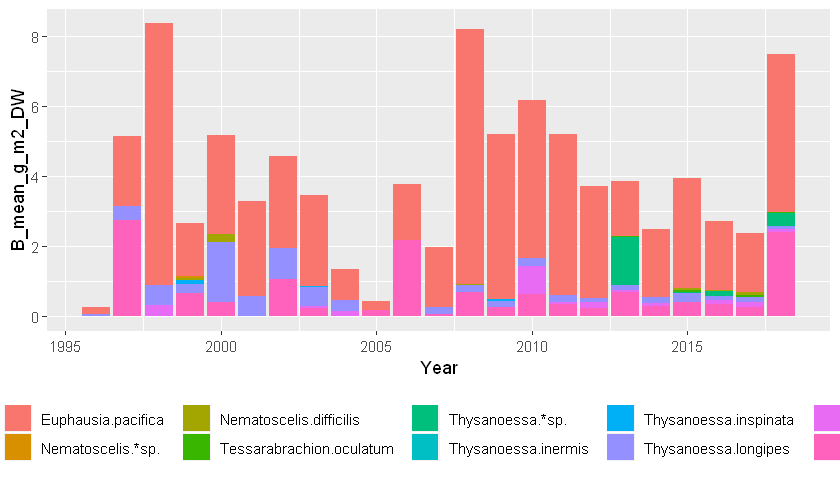

In [304]:
ggplot(filter(df_2_yr_mean_euph, B_mean_g_m2_DW > 0.01), aes(fill=Genus_species, y=B_mean_g_m2_DW, x=Year)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom")

# Seasonal  

In [85]:
df_2_summary

season,Phylum,Class,Order,Family,Genus,Species,Genus_species,modelgroup,B_sum_g_m2_DW,B_sum_g_m2_WW,B_sum_mg_m3_DW,B_sum_mg_m3_WW,AdultBody_size_mg_mean,n,n_occurrences,B_mean_g_m2_DW,B_mean_g_m2_WW,B_mean_mg_m3_DW,B_mean_mg_m3_WW,adj_DW_g_m2,adj_WW_g_m2
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
summer,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,72.24,541.83,342.61,2569.57,7.9680000,760,20,3.28,24.63,15.57,116.80,2.14,16.03
fall,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,65.64,492.30,283.72,2127.91,8.5000000,760,17,2.98,22.38,12.90,96.72,1.77,13.27
spring,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,61.69,308.45,219.98,1099.90,0.6014286,760,21,2.80,14.02,10.00,50.00,1.37,6.86
summer,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,55.88,223.52,198.27,793.08,5.7000000,760,20,2.54,10.16,9.01,36.05,1.24,4.95
summer,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,54.88,384.16,198.49,1389.43,0.1400000,760,20,2.49,17.46,9.02,63.16,1.24,8.67
fall,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,46.90,187.60,160.75,643.00,5.7000000,760,18,2.13,8.53,7.31,29.23,1.00,4.01
summer,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,45.55,227.75,141.22,706.10,0.5545000,760,20,2.07,10.35,6.42,32.10,0.88,4.41
fall,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,42.68,213.40,128.13,640.65,0.5552941,760,17,1.94,9.70,5.82,29.12,0.80,4.00
spring,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,41.14,287.98,147.08,1029.56,0.1400000,760,21,1.87,13.09,6.69,46.80,0.92,6.42


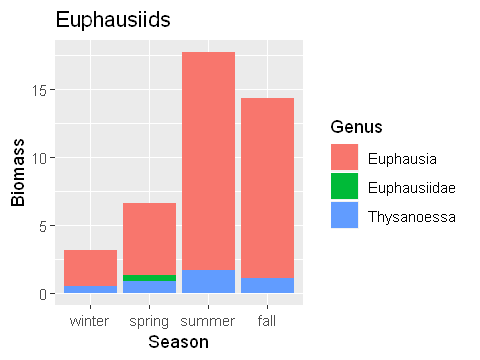

## ZC1-EUP - Seasonal Euphausiids

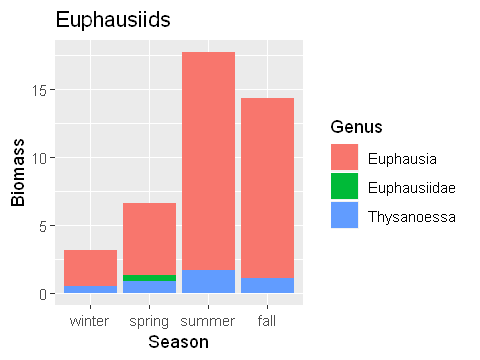

In [111]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(modelgroup=="ZC1-EUP") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


p_ZC1_EUP <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.1), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Euphausiids", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZC1_EUP

# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Order=="Euphausiacea") %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))



# p_ZC1_EUP <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 1), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Euphausiids", y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZC1_EUP

## ZC2-AMP Seasonal Amphipods

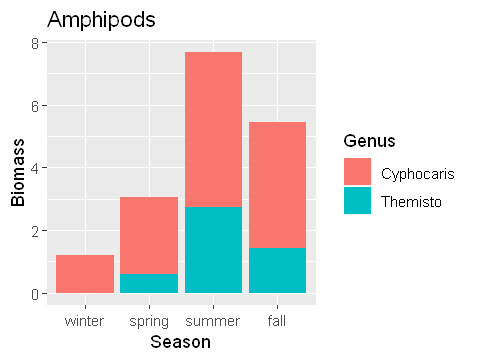

In [110]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(modelgroup=="ZC2-AMP") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Order=="Amphipoda") %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


p_ZC2_AMP <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.3), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Amphipods", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZC2_AMP

## ZC3-DEC - Seasonal Decapods

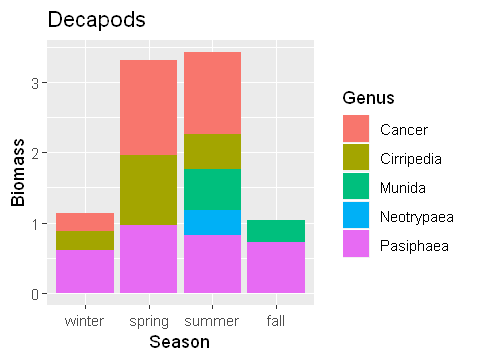

In [109]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(modelgroup=="ZC3-DEC") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZC3_DEC <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.2), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Decapods", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZC3_DEC

# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Order=="Decapoda") %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# p_ZC3_DEC <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 0.4), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Decapods", y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZC3_DEC

In [100]:
df_2_summary

season,Phylum,Class,Order,Family,Genus,Species,Genus_species,modelgroup,B_sum_g_m2_DW,B_sum_g_m2_WW,B_sum_mg_m3_DW,B_sum_mg_m3_WW,AdultBody_size_mg_mean,n,n_occurrences,B_mean_g_m2_DW,B_mean_g_m2_WW,B_mean_mg_m3_DW,B_mean_mg_m3_WW,adj_DW_g_m2,adj_WW_g_m2
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
summer,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,72.24,541.83,342.61,2569.57,7.9680000,760,20,3.28,24.63,15.57,116.80,2.14,16.03
fall,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,ZC1-EUP,65.64,492.30,283.72,2127.91,8.5000000,760,17,2.98,22.38,12.90,96.72,1.77,13.27
spring,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,61.69,308.45,219.98,1099.90,0.6014286,760,21,2.80,14.02,10.00,50.00,1.37,6.86
summer,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,55.88,223.52,198.27,793.08,5.7000000,760,20,2.54,10.16,9.01,36.05,1.24,4.95
summer,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,54.88,384.16,198.49,1389.43,0.1400000,760,20,2.49,17.46,9.02,63.16,1.24,8.67
fall,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,ZC2-AMP,46.90,187.60,160.75,643.00,5.7000000,760,18,2.13,8.53,7.31,29.23,1.00,4.01
summer,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,45.55,227.75,141.22,706.10,0.5545000,760,20,2.07,10.35,6.42,32.10,0.88,4.41
fall,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,ZC4-CLG,42.68,213.40,128.13,640.65,0.5552941,760,17,1.94,9.70,5.82,29.12,0.80,4.00
spring,Arthropoda,Maxillopoda,Calanoida,Metridinidae,Metridia,pacifica,Metridia.pacifica,ZC5-CSM,41.14,287.98,147.08,1029.56,0.1400000,760,21,1.87,13.09,6.69,46.80,0.92,6.42


## ZC4-CLG - Seasonal copepods lg

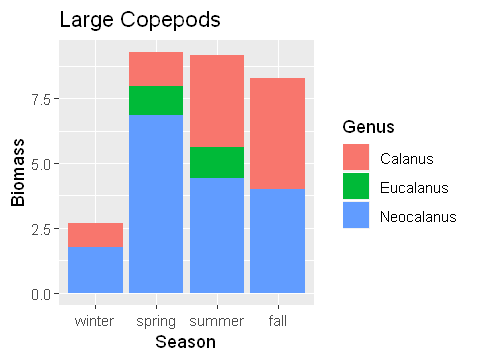

In [157]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(modelgroup=="ZC4-CLG") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZC4_CLG <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.8), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Large Copepods", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZC4_CLG


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Order=="Calanoida" | Order=="Oithona") %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# p_ZC4_CLG <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 1.6), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Large Copepods",y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZC4_CLG

## ZC5-CSM - Seasonal copepods sm

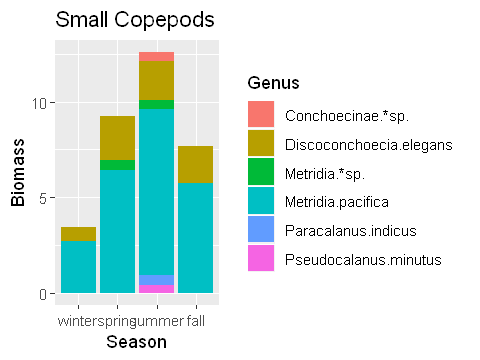

In [158]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(modelgroup=="ZC5-CSM") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZC5_CSM <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.4), aes(fill=Genus_species, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Small Copepods", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZC5_CSM


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Order=="Calanoida" | Order=="Cyclopoida") %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# p_ZC4_CSM <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 2), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Small Copepods",y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZC4_CSM 

## ZS4-LAR Seasonal Larvacean / Appendicularian / Tunicates

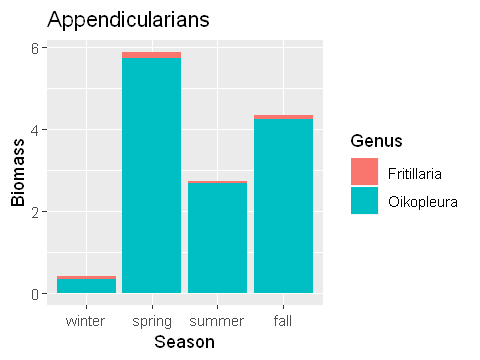

In [113]:
options(repr.plot.width=4, repr.plot.height=3)

options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(modelgroup=="ZS4-LAR") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZS4_LAR <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Appendicularians", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZS4_LAR


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Class=="Appendicularia") %>%
#    group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# p_ZS4_LAR <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 0.001), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Larvaceans", y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZS4_LAR

## ZS3-CHA

## Seasonal Chaetognaths

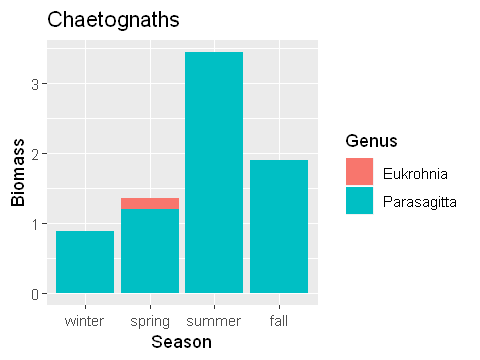

In [124]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(Phylum=="Chaetognatha") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZS3_CHA <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.06), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Chaetognaths", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZS3_CHA

# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(modelgroup=="ZS3-CHA") %>%
#    group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

# p_ZS3_CHA_1 <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 0.08), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Chaetognaths", y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZS3_CHA_1

## Pteropods (Molluscs, Ostrocods, Gastropods) - Limacina helicina Clione limacina

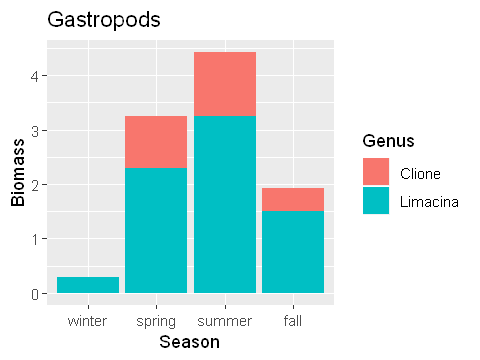

In [155]:

options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(Class=="Gastropoda") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_PTE <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.2), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Gastropods", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_PTE



# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Class=="Gastropoda") %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 0.4), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Gastropods", y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")

## Seasonal Polychaeta

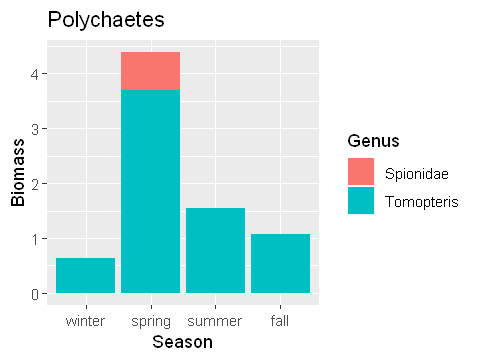

In [125]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(Class=="Polychaeta") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZS3_CHA <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.3), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Polychaetes", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZS3_CHA


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Class=="Polychaeta") %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# p_ZS3_CHA_2 <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 0.6), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Polychaetes",y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZS3_CHA_2 

## Deciding cut-offs in body sizes for Medium and Large Jellies / Ctenos
## just notes - see above

In [81]:
df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
    filter(Phylum=="Ctenophora" | Phylum == "Cnidaria") %>%
    group_by(season,Phylum,Class,Order, Genus) %>%
    summarise(B_mean_g_m2_DW = mean(round(B_mean_g_m2_DW, digits=2)),
              AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2)),
              n_surv_yrseas = mean(n_surv_yrseas), #
              n_occurrences = n()) %>%
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))



`summarise()` regrouping output by 'season', 'Phylum', 'Class', 'Order' (override with `.groups` argument)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


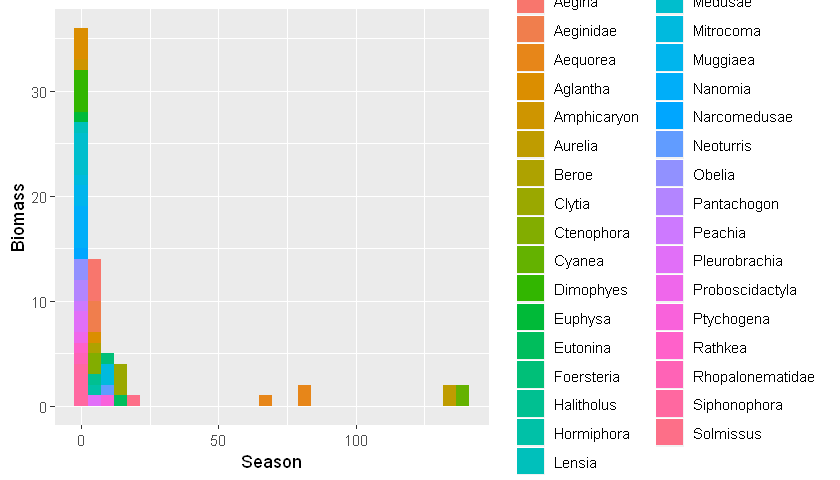

In [83]:
ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_DW > 0.01 & AdultBody_size_mg_mean > 0.001), aes(AdultBody_size_mg_mean, fill=Genus)) + 
    geom_histogram() +  
    theme(legend.position="bottom") + 
    labs(y="Biomass", x = "Season", fill="Genus_species") + 
    theme(legend.position = "right")

## ZS2-CTH - Ctenophores and Small Hydrozoans Seasonal

## Ctenophores

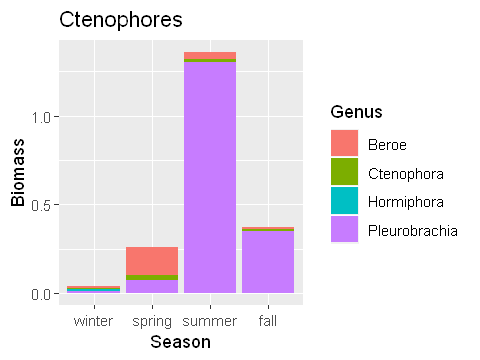

In [132]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(Phylum=="Ctenophora") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZS4_CTH_1 <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.009), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Ctenophores", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZS4_CTH_1


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Phylum=="Ctenophora") %>%
#    group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# p_ZS2_CTH_1 <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 0.1), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Ctenophores", y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZS2_CTH_1

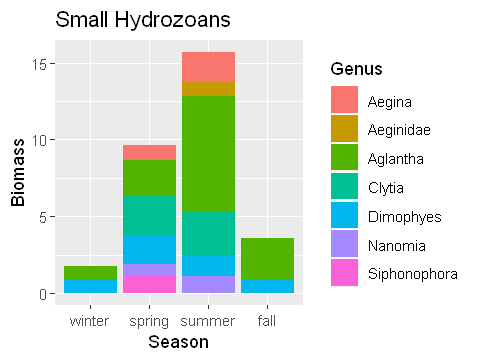

In [136]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(Phylum=="Cnidaria" & Class=="Hydrozoa" & Family!="Aequoreidae") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZS4_CTH_2 <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.6), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Small Hydrozoans", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZS4_CTH_2


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter((Phylum=="Cnidaria" & Class=="Hydrozoa" & Family!="Aequoreidae")) %>%
#    group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# p_ZS2_CTH_2 <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 2.3), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Small Hydrozoans", y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZS2_CTH_2

## ZS1-JEL - Jelly / Cnidaria seasonal

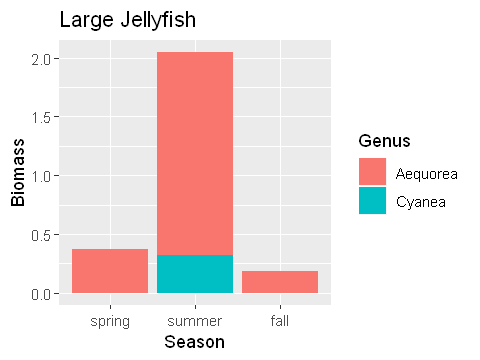

In [142]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(modelgroup=="ZS1-JEL") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZS1_JEL <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.1), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Large Jellyfish", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZS1_JEL


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Phylum=="Cnidaria" & (Class=="Scyphozoa" | Family=="Aequoreidae")) %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# p_ZS1_JEL <- ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 0.0001), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(title="Jellyfish",y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")
# p_ZS1_JEL

## ZF1-FIS - Fish - Seasonal

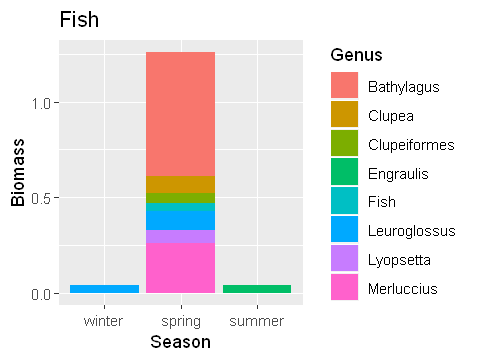

In [154]:
options(repr.plot.width=4, repr.plot.height=3)

df_summary_grp = df_2_summary %>%
    filter(modelgroup=="ZF1-FIS") %>%
    arrange(desc(adj_WW_g_m2), .by_group = FALSE) %>%
    mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))

p_ZF1_FIS <- ggplot(filter(df_summary_grp, adj_WW_g_m2 > 0.03), aes(fill=Genus, y=adj_WW_g_m2, x=season)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom") + 
    labs(title="Fish", y="Biomass", x = "Season", fill="Genus") + 
    theme(legend.position = "right")
p_ZF1_FIS


# df_2_yrseas_mean_grp = df_2_yrseas_mean %>%
#     filter(Phylum=="Chordata" & Class!="Appendicularia") %>%
#     group_by(season,Year,Phylum,Class,Order, Genus) %>%
#     # first take sum of B and mean of body size for the above grouping
#     summarise(B_sum_g_m2_WW = sum(round(B_mean_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     group_by(season,Phylum,Class,Order, Genus) %>%
#     # get mean of B across years by season
#     summarise(B_mean_g_m2_WW = mean(round(B_sum_g_m2_WW, digits=2)),
#               AdultBody_size_mg_mean = mean(round(AdultBody_size_mg_mean, digits=2))) %>%
#     arrange(desc(B_mean_g_m2_WW), .by_group = FALSE) %>%
#     mutate(season = factor(season, levels=c("winter", "spring", "summer", "fall")))


# options(repr.plot.width=7, repr.plot.height=4)
# ggplot(filter(df_2_yrseas_mean_grp, B_mean_g_m2_WW > 0.001), aes(fill=Genus, y=B_mean_g_m2_WW, x=season)) + 
#     geom_bar(position="stack", stat="identity") +  
#     theme(legend.position="bottom") + 
#     labs(y="Biomass", x = "Season", fill="Genus") + 
#     theme(legend.position = "right")

In [455]:
df_2 %>% filter(Genus=="Bathylagus") %>% count(season,Year)

season,Year,n
<chr>,<int>,<int>
spring,2000,1
spring,2006,1
spring,2014,2
spring,2015,1
summer,2004,1
summer,2009,1
winter,2008,2


In [583]:
grid.arrange(p_ZS1_JEL, p_ZS2_CTH, nrow = 1)


ERROR: Error in grid.arrange(p_ZS1_JEL, p_ZS2_CTH, nrow = 1): could not find function "grid.arrange"


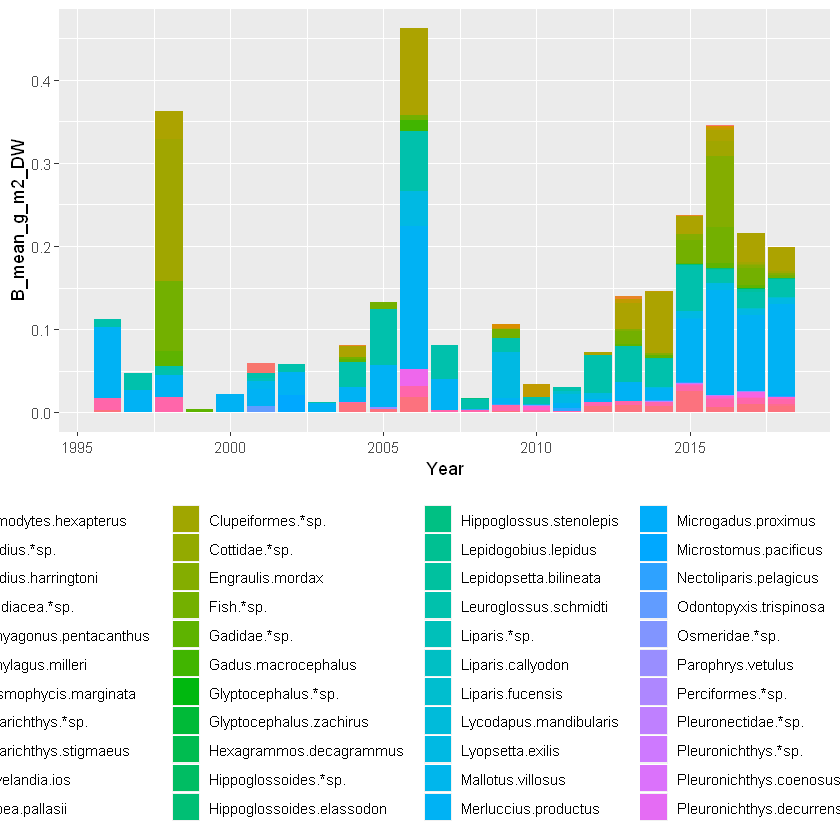

In [22]:
ggplot(filter(df_2_yr_mean_fish, Genus_species != "Bathylagus.*sp."), aes(fill=Genus_species, y=B_mean_g_m2_DW, x=Year)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom")

In [456]:
df_2_seasyr_specieslev %>% filter(Genus_species == "Bathylagus.*sp.")

Year,season,Phylum,Class,Order,Family,Genus,Species,Genus_species,n_surveys,count_surveys_yr,count_surveys_yrseas,B_mean_mg_m3_DW,B_mean_g_m2_DW,Abundance_mean_m3,AdultBody_mean_size_mg,modelgroup,B_mean_g_m2_WW
<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2000,spring,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,760,4,2,20.89,5.22,0.55,76.30,ZF1-FIS,34.7652
2004,summer,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,760,27,3,0.00,0.00,0.05,0.02,ZF1-FIS,0.0000
2006,spring,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,760,9,5,0.00,0.00,0.10,0.02,ZF1-FIS,0.0000
2008,winter,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,760,30,2,0.00,0.00,0.16,0.02,ZF1-FIS,0.0000
2014,spring,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,760,37,12,0.00,0.00,1.58,0.02,ZF1-FIS,0.0000
2015,spring,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,760,137,65,0.00,0.00,2.05,0.02,ZF1-FIS,0.0000


`summarise()` ungrouping output (override with `.groups` argument)


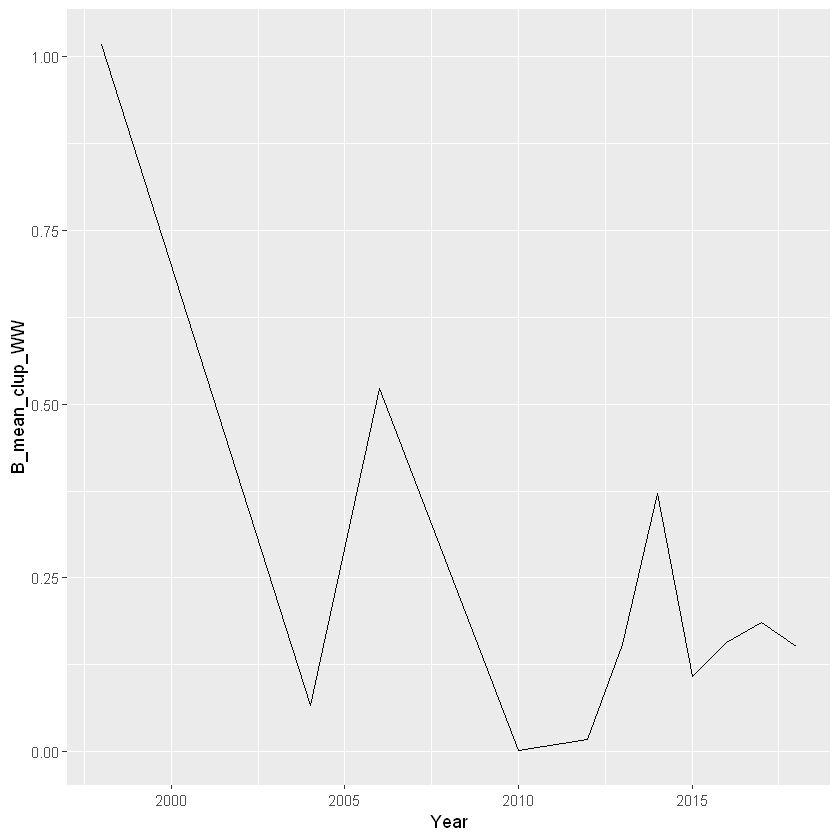

In [24]:
# grab just herring to compare to Boldt's stats

df_2_yr_mean_fish %>% 
filter(Genus_species == "Clupeiformes.*sp." | Genus_species == "Clupea.pallasii") %>%
group_by(Year) %>%
arrange(Year) %>%
summarize(B_mean_clup_WW = sum(B_mean_g_m2_DW * 5)) %>% 

ggplot(y=B_mean_clup_WW, x=Year) + 
geom_line(aes(y=B_mean_clup_WW, x=Year)) +
    theme(legend.position="bottom")
# 

In [88]:
# grab hake as separate TS

df_2_yr_mean_fish %>% 

Year,Phylum,Class,Order,Family,Genus,Species,Genus_species,B_sum_g_m2_DW,Body_size_mg_mean,n_surv_yr,n_occurrences,B_mean_g_m2_DW
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1998,Chordata,Actinopterygii,Clupeiformes,Clupeiformes,Clupeiformes,*sp.,Clupeiformes.*sp.,3.41,2.600000,20,1,0.1705000000
1998,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.66,6.870000,20,2,0.0330000000
2004,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.36,4.023333,27,3,0.0133333333
2006,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.94,4.735000,9,2,0.1044444444
2010,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.01,2.600000,21,1,0.0004761905
2012,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.06,6.870000,17,2,0.0035294118
2013,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.83,3.667500,27,4,0.0307407407
2014,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,2.75,4.735000,37,2,0.0743243243
2015,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,2.92,4.655833,137,24,0.0213138686


In [25]:
df_2_yr_mean_fish %>% filter(Genus == "Clupeiformes" | Genus == "Clupea") 

Year,Phylum,Class,Order,Family,Genus,Species,Genus_species,B_sum_g_m2_DW,Body_size_mg_mean,n_surv_yr,n_occurrences,B_mean_g_m2_DW
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1998,Chordata,Actinopterygii,Clupeiformes,Clupeiformes,Clupeiformes,*sp.,Clupeiformes.*sp.,3.41,2.600000,20,1,0.1705000000
2006,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.94,4.735000,9,2,0.1044444444
2014,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,2.75,4.735000,37,2,0.0743243243
2017,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,3.19,4.735000,93,16,0.0343010753
1998,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.66,6.870000,20,2,0.0330000000
2013,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.83,3.667500,27,4,0.0307407407
2018,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,1.65,5.345000,60,14,0.0275000000
2015,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,2.92,4.655833,137,24,0.0213138686
2016,Chordata,Actinopterygii,Clupeiformes,Clupeiformes,Clupeiformes,*sp.,Clupeiformes.*sp.,2.88,0.795000,158,20,0.0182278481
